In [1]:
import os
import ioh
import numpy as np
import pickle
import pandas as pd
from functools import partial
from glob import glob

import seaborn as sbs
import matplotlib.pyplot as plt

from scipy.stats import kendalltau, rankdata

font = {'size'   : 24}

plt.rc('font', **font)

# Font-requirement for GECCO
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [2]:
def load_data(force_load=False):
    if os.path.isfile("data/ecdf_data.pkl") or force_load:
        return pd.read_pickle("data/ecdf_data.pkl")

    tgt = os.path.realpath(os.path.join(".", "data/auc_repelling"))
    files = os.listdir(tgt)

    data = []
    for i, file in enumerate(files):
        print(i, len(files), file)
        df = pd.read_csv(os.path.join(tgt, file), on_bad_lines='skip')
        df = df[df.run_id < 100]
        df = df.drop(df.columns[0], axis=1)

        for budget in 10 ** np.arange(0, 7, 0.1):
            dt_temp = (
                df[["run_id", "fid", "dim", "version", "evaluations", "ecdf"]]
                .query(f"evaluations < {int(budget)}")
                .groupby(["run_id", "fid", "dim", "version"])
                .agg("max")["ecdf"]
                .reset_index()
            )
            dt_temp["budget"] = int(budget)
            data.append(dt_temp)

    data = pd.concat(data)
    data['elitist'] = data.version.str.endswith("elitist")
    data['repelling'] = data.version.str.contains("repelling")
    data['IPOP'] = data.version.str.contains("-IPOP")
    data['BIPOP'] = data.version.str.contains("BIPOP")
    data['coverage'] = data.version.str.rsplit("c", n=1, expand=True)[1].str.rsplit(".0", n=1, expand=True)[0].astype(float)
    data['coverage'] = data['coverage'].fillna(0)
    s = np.ones(len(data), dtype=object)
    s[:] = 'RESTART'
    s[data.IPOP.values] = 'IPOP'
    s[data.BIPOP.values] = 'BIPOP'
    data['strategy'] = s
    data.to_pickle("data/ecdf_data.pkl")
    return data

data = load_data()

In [3]:
data.head()

run_id  fid  dim                           version      ecdf  budget  \
0       1   17   10  CMA-ES-RESTART-repelling-c1000.0  0.004010       2   
1       2   17   10  CMA-ES-RESTART-repelling-c1000.0  0.000000       2   
2       3   17   10  CMA-ES-RESTART-repelling-c1000.0  0.096704       2   
3       4   17   10  CMA-ES-RESTART-repelling-c1000.0  0.046996       2   
4       5   17   10  CMA-ES-RESTART-repelling-c1000.0  0.009215       2   

   elitist  coverage  repelling   IPOP  BIPOP strategy  
0    False    1000.0       True  False  False  RESTART  
1    False    1000.0       True  False  False  RESTART  
2    False    1000.0       True  False  False  RESTART  
3    False    1000.0       True  False  False  RESTART  
4    False    1000.0       True  False  False  RESTART

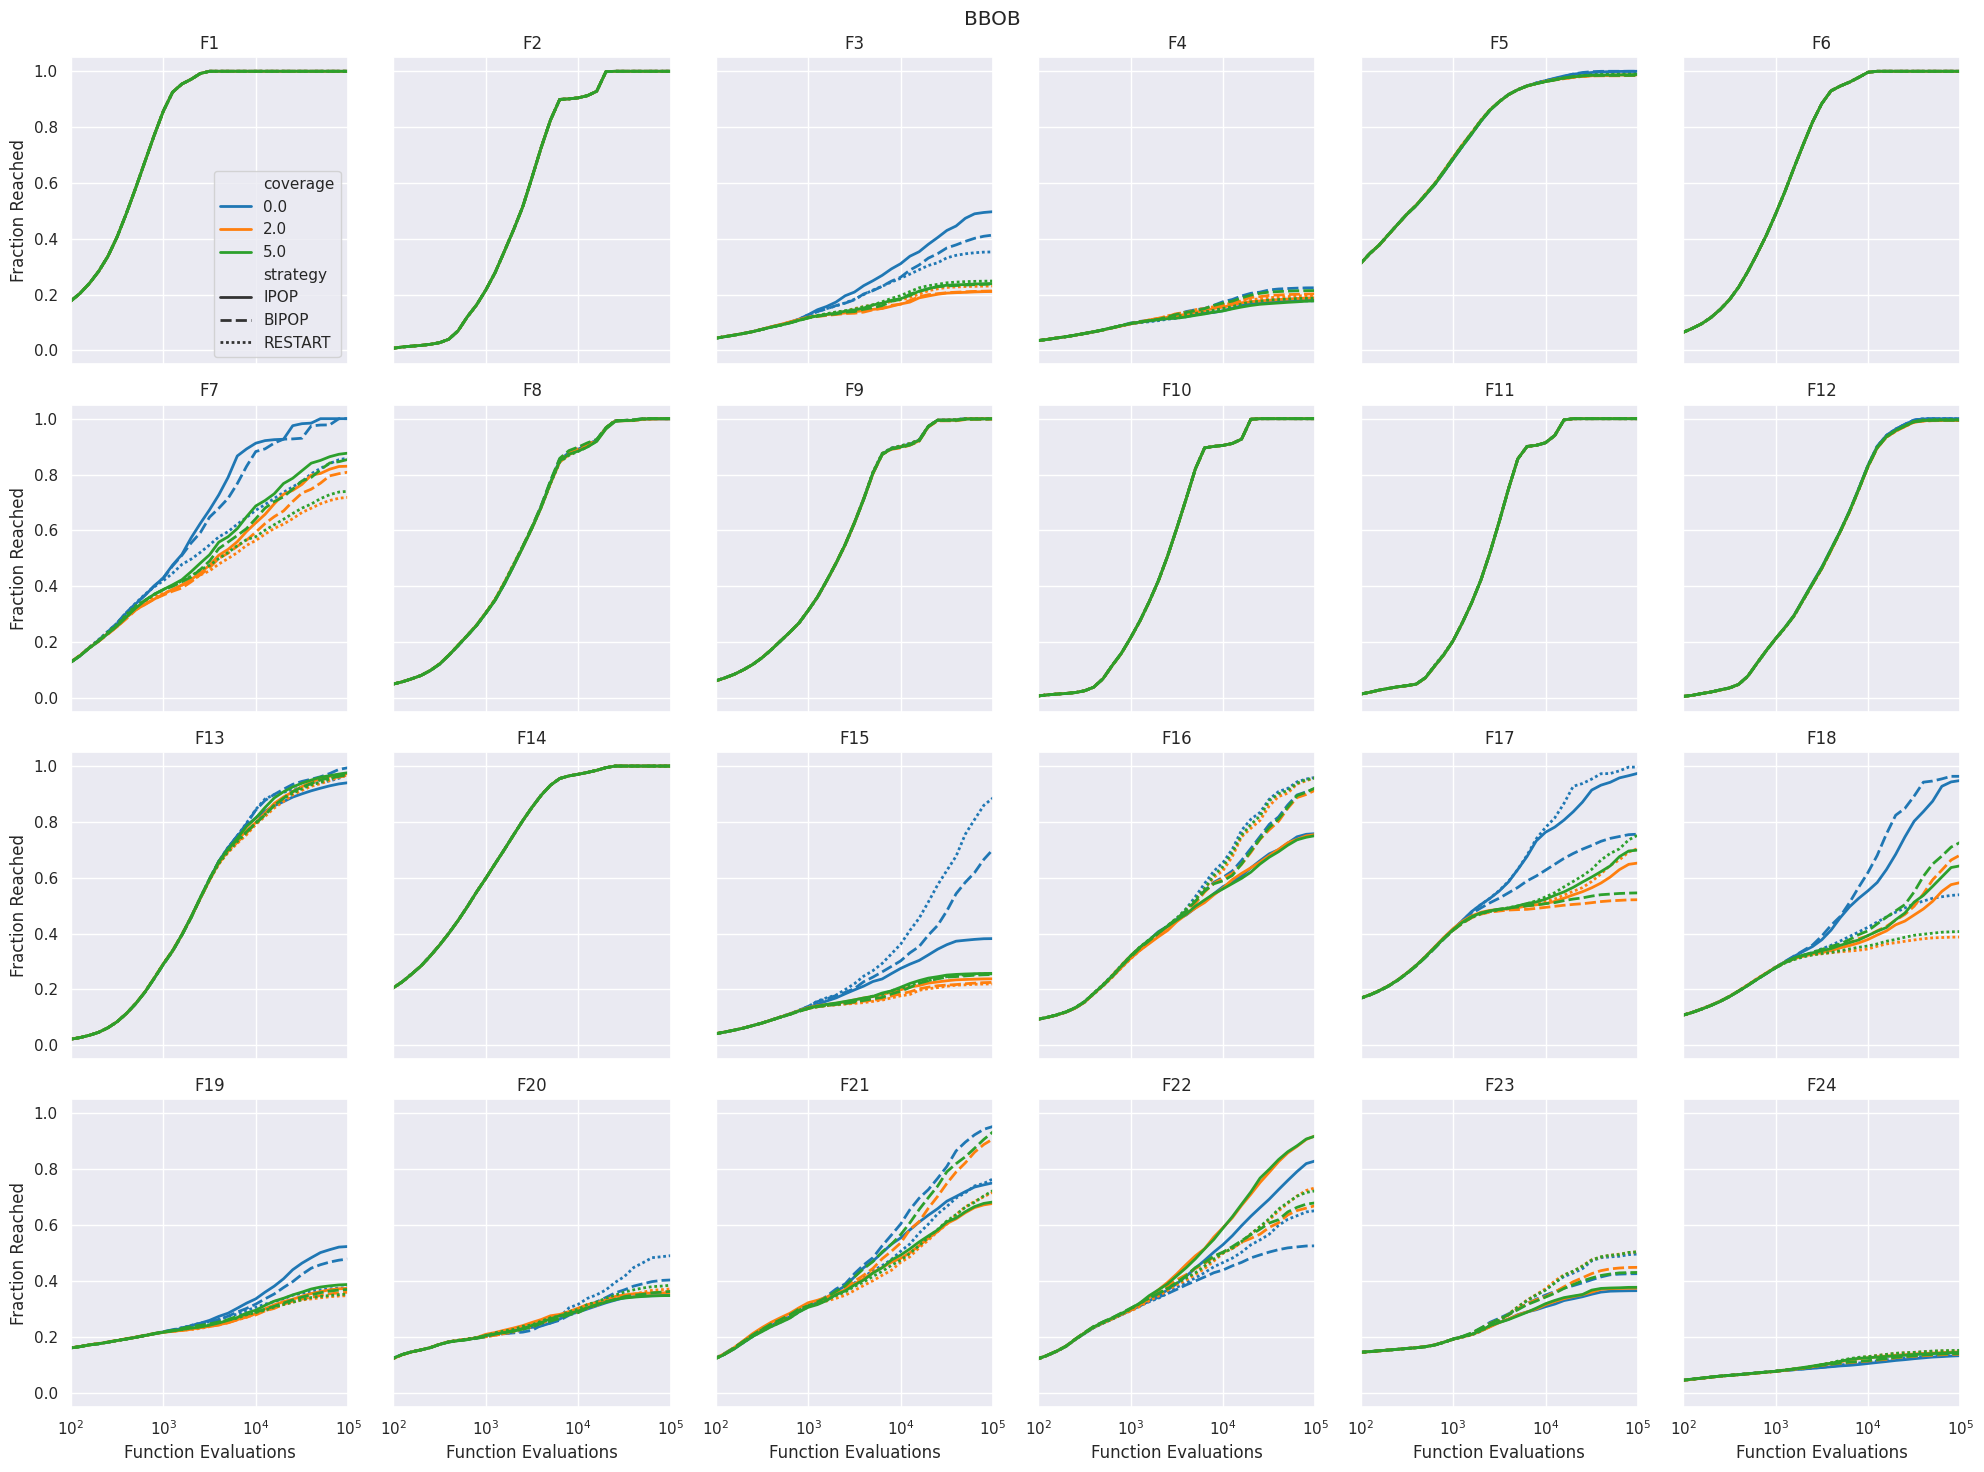

In [48]:
f, axes = plt.subplots(4, 6, figsize=(20, 15), sharey=True, sharex=True)
f.suptitle("BBOB")
for fid, ax  in zip(range(1, 25), axes.ravel()):
    sbs.set_theme(style="darkgrid")
    sbs.lineplot(
        data.query(
            f"fid == {fid} & coverage < 10 & elitist == False"
        ).sort_values("coverage"),
        x="budget",
        y="ecdf",
        hue="coverage",
        style="strategy", 
        errorbar=None,
        palette='tab10',
        lw=2,
        ax=ax
    )
    ax.set_xscale("log")
    ax.set_title(f"F{fid}")
    ax.set_xlim(1e3, 1e5)
    ax.set_ylabel("Fraction Reached")
    ax.set_xlabel("Function Evaluations")

    if fid > 1:
        ax.get_legend().remove()

plt.tight_layout()
plt.savefig("figures/bbob_ecdf.pdf")

/tmp/ipykernel_118753/997191858.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sbs.lineplot(


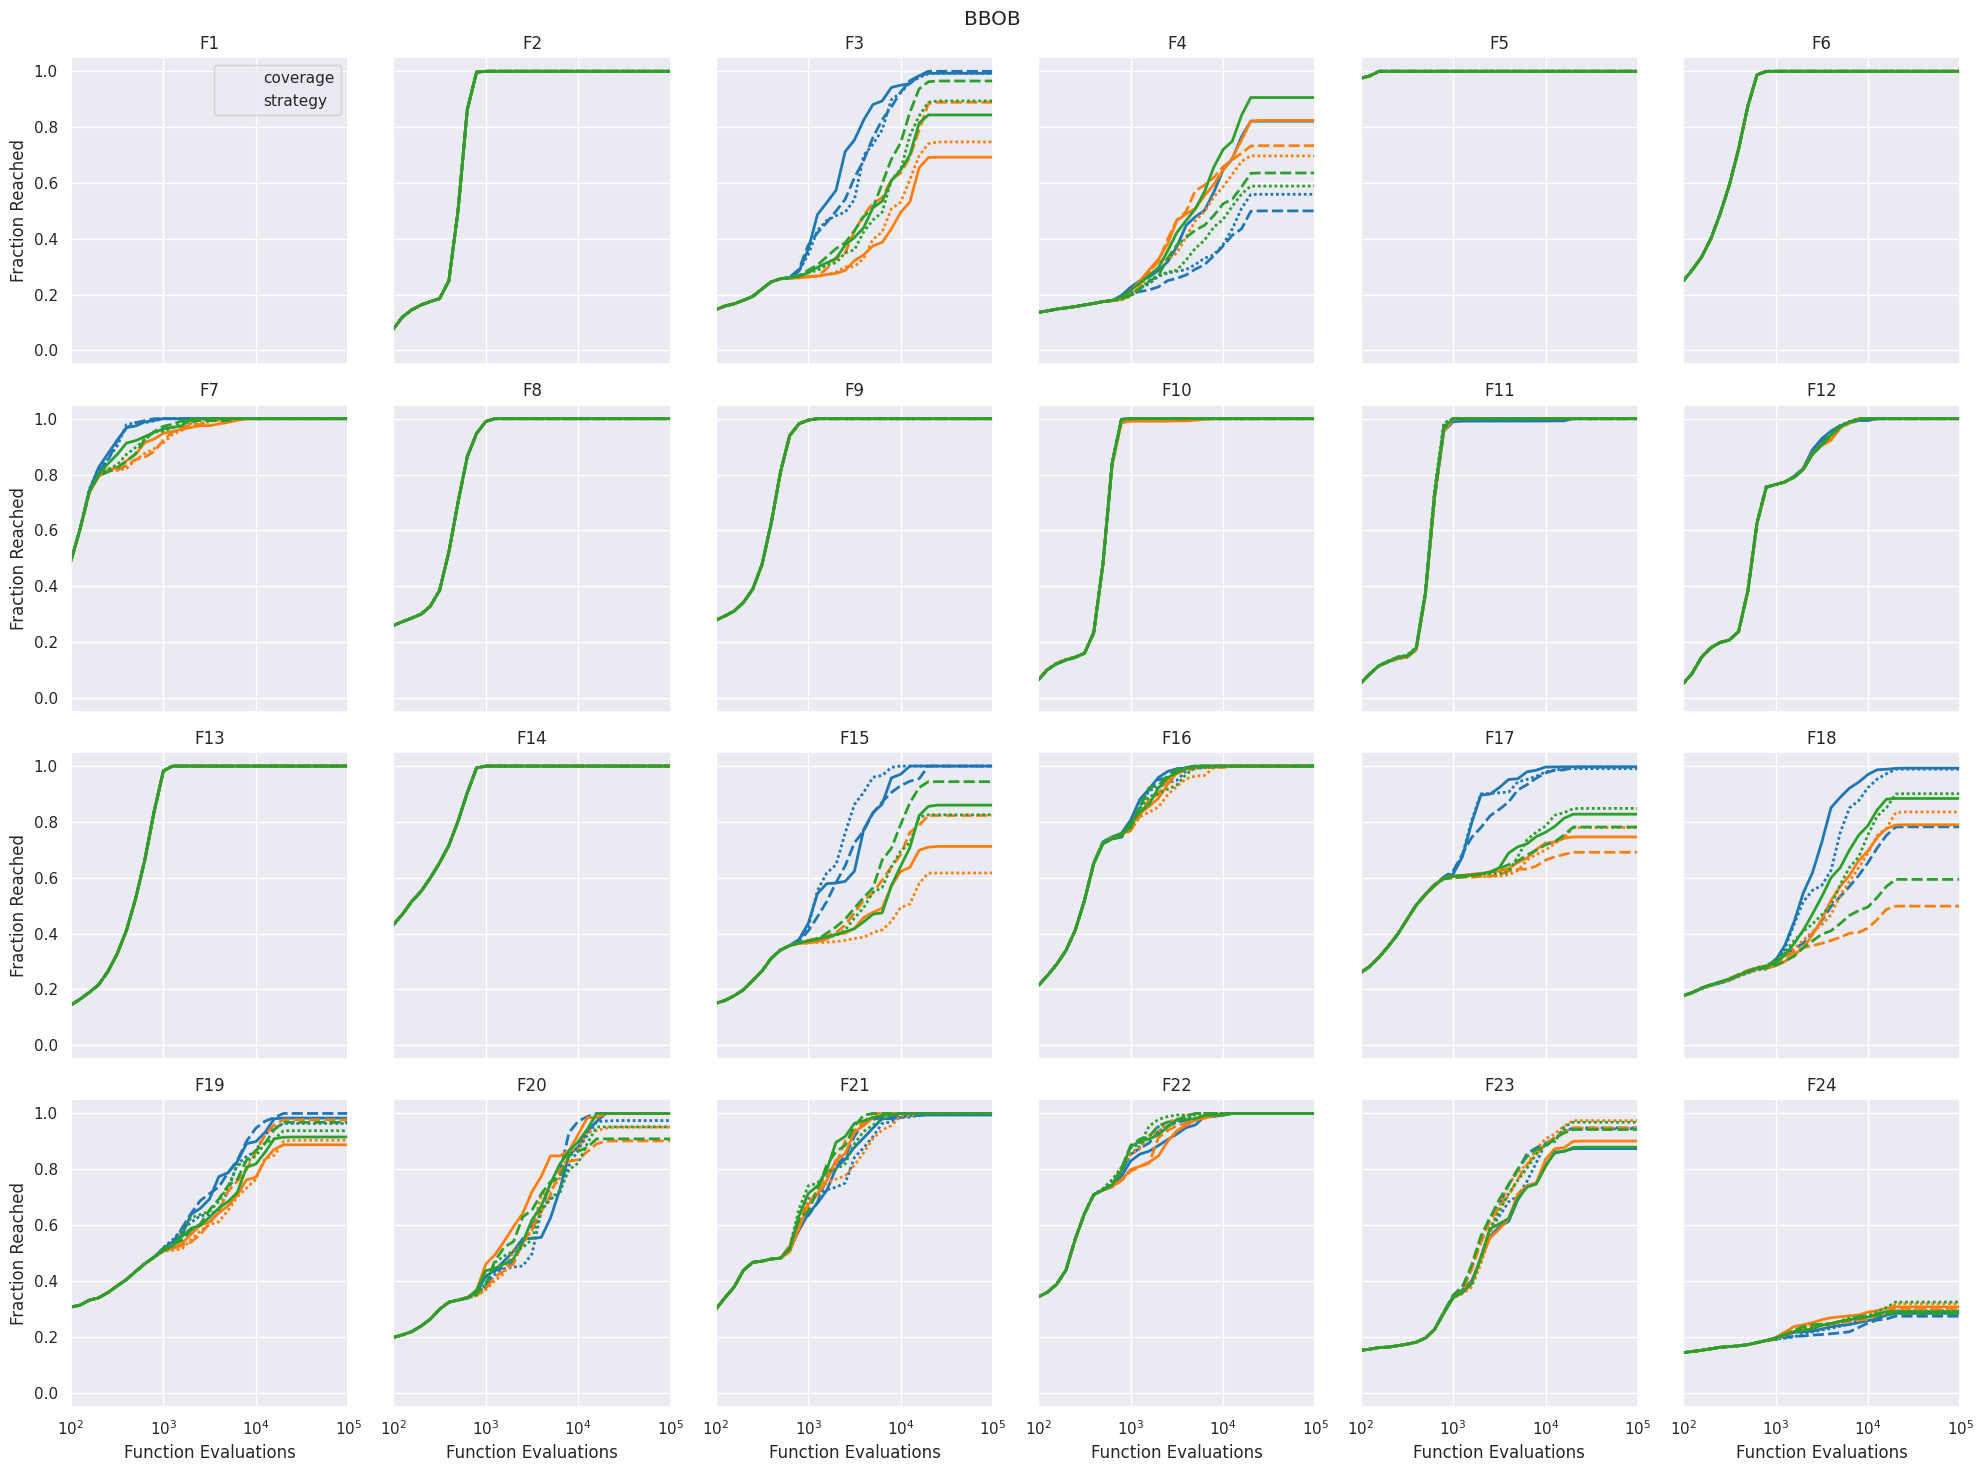

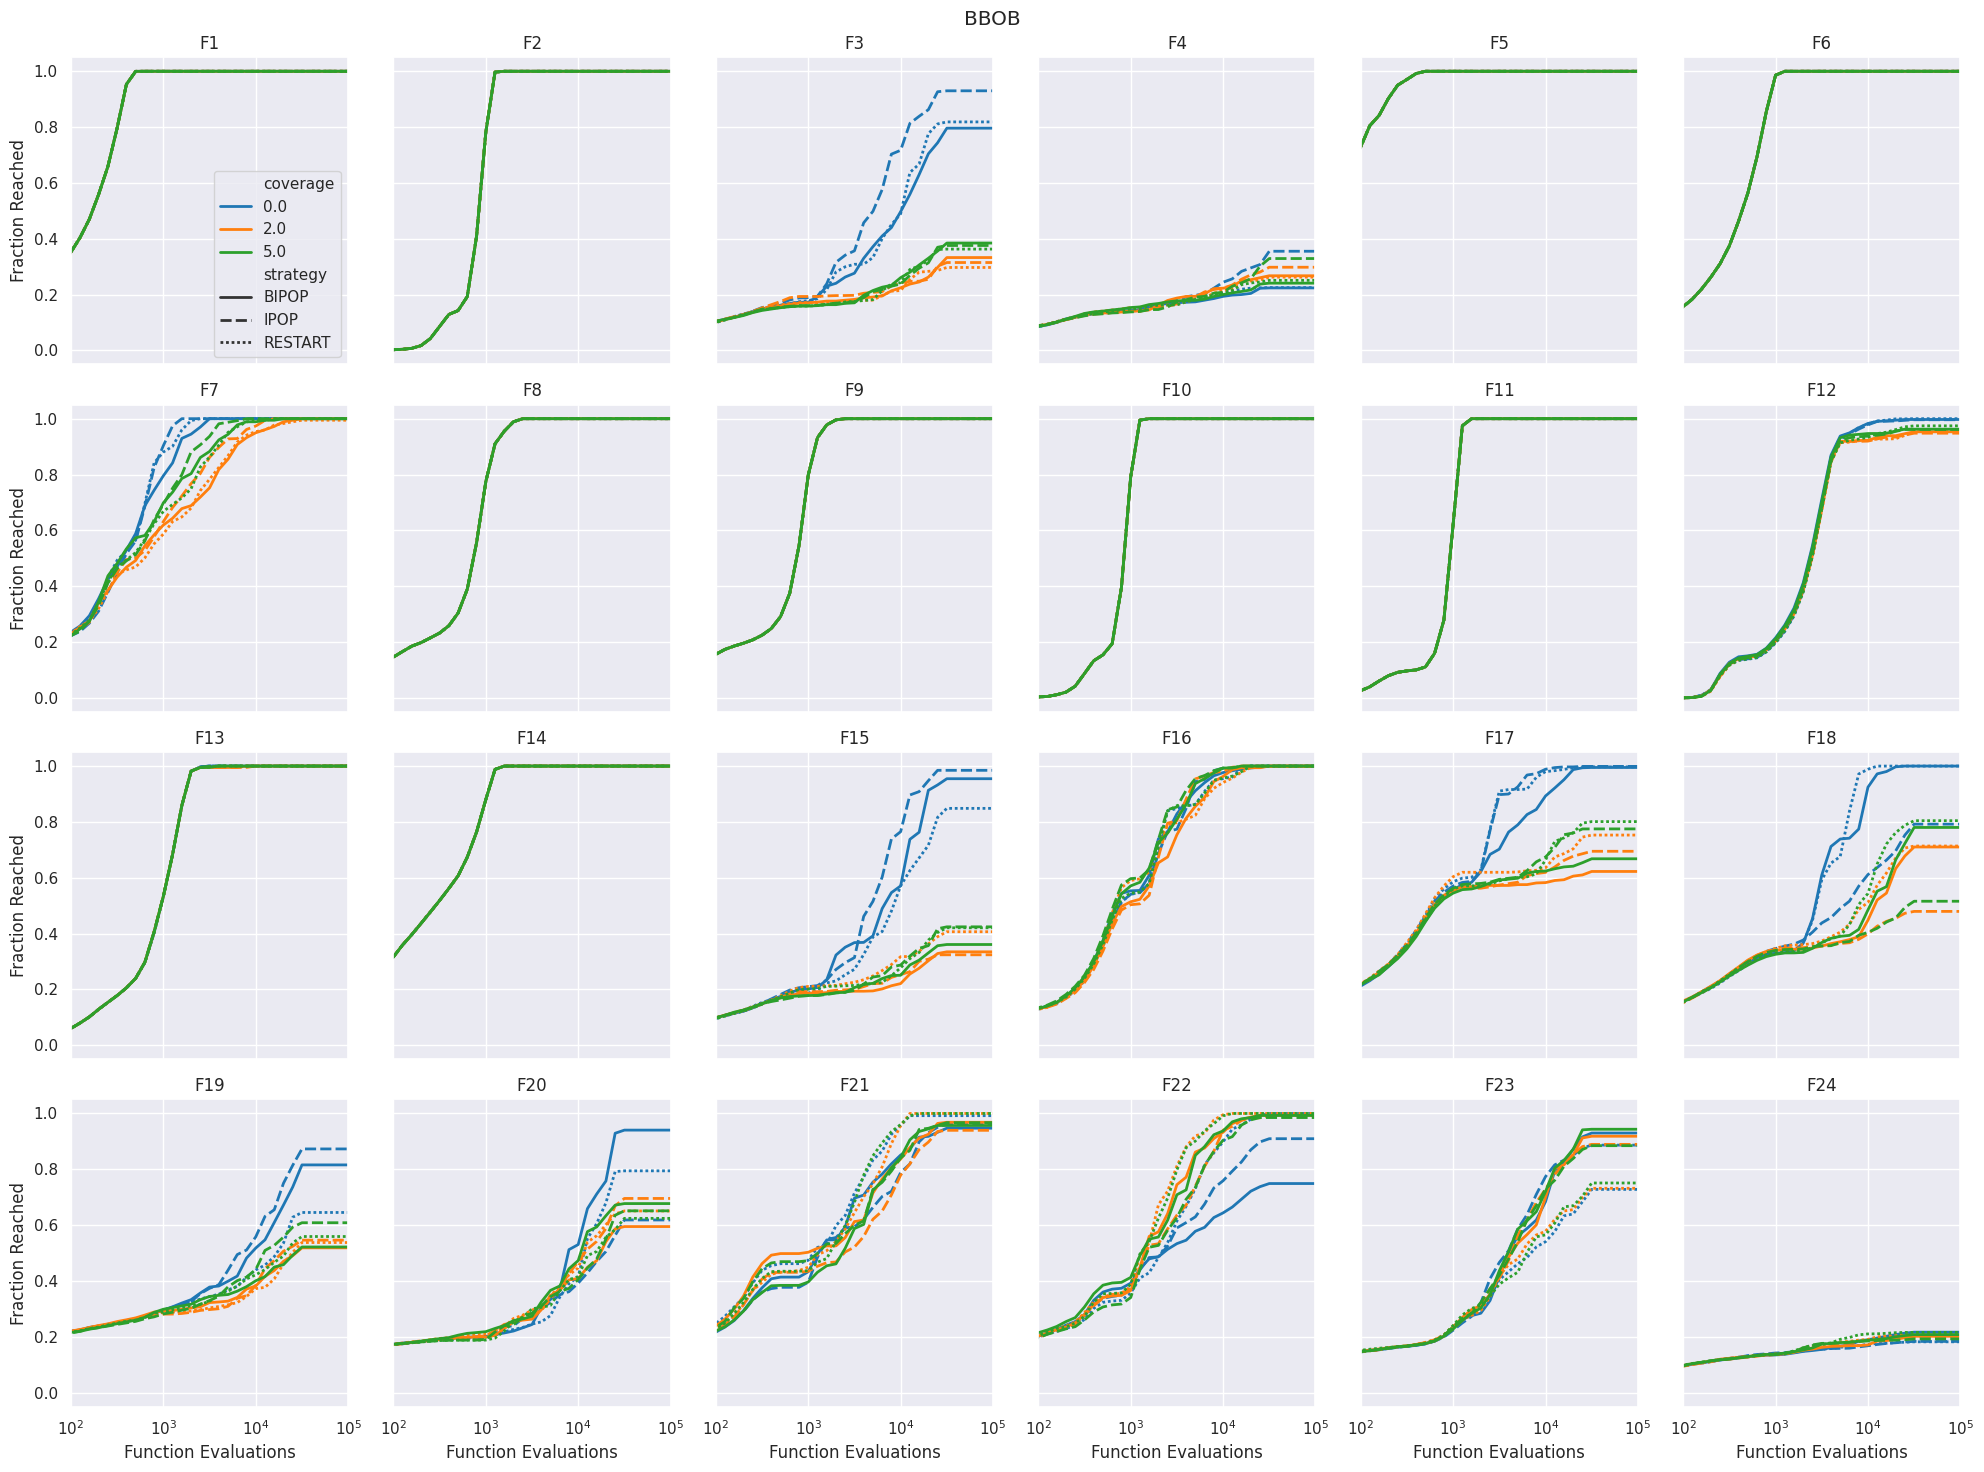

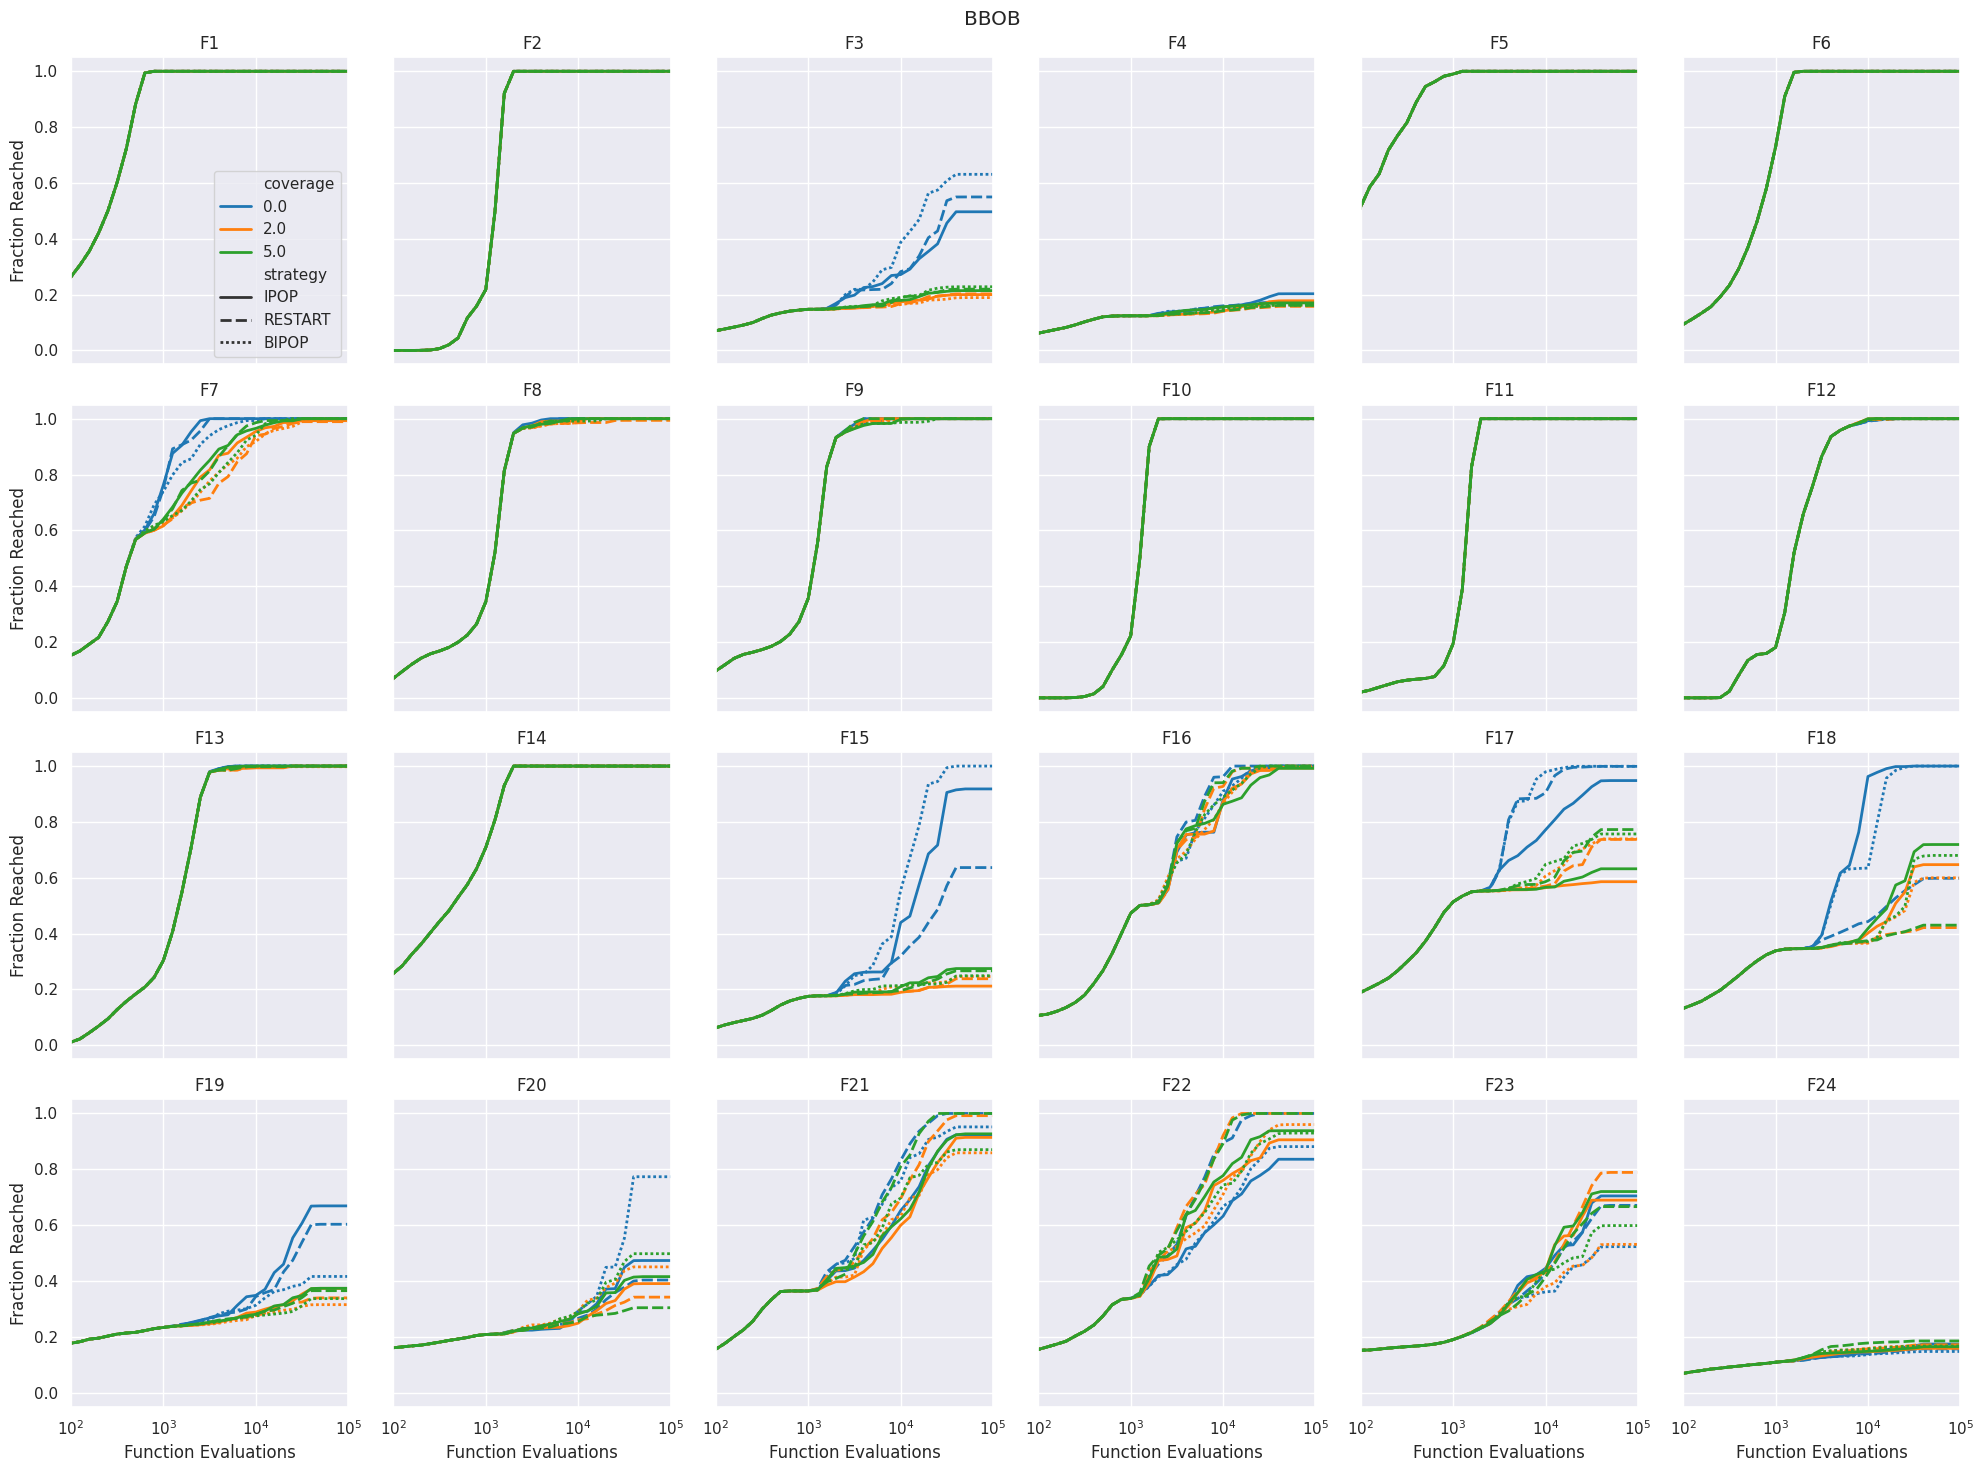

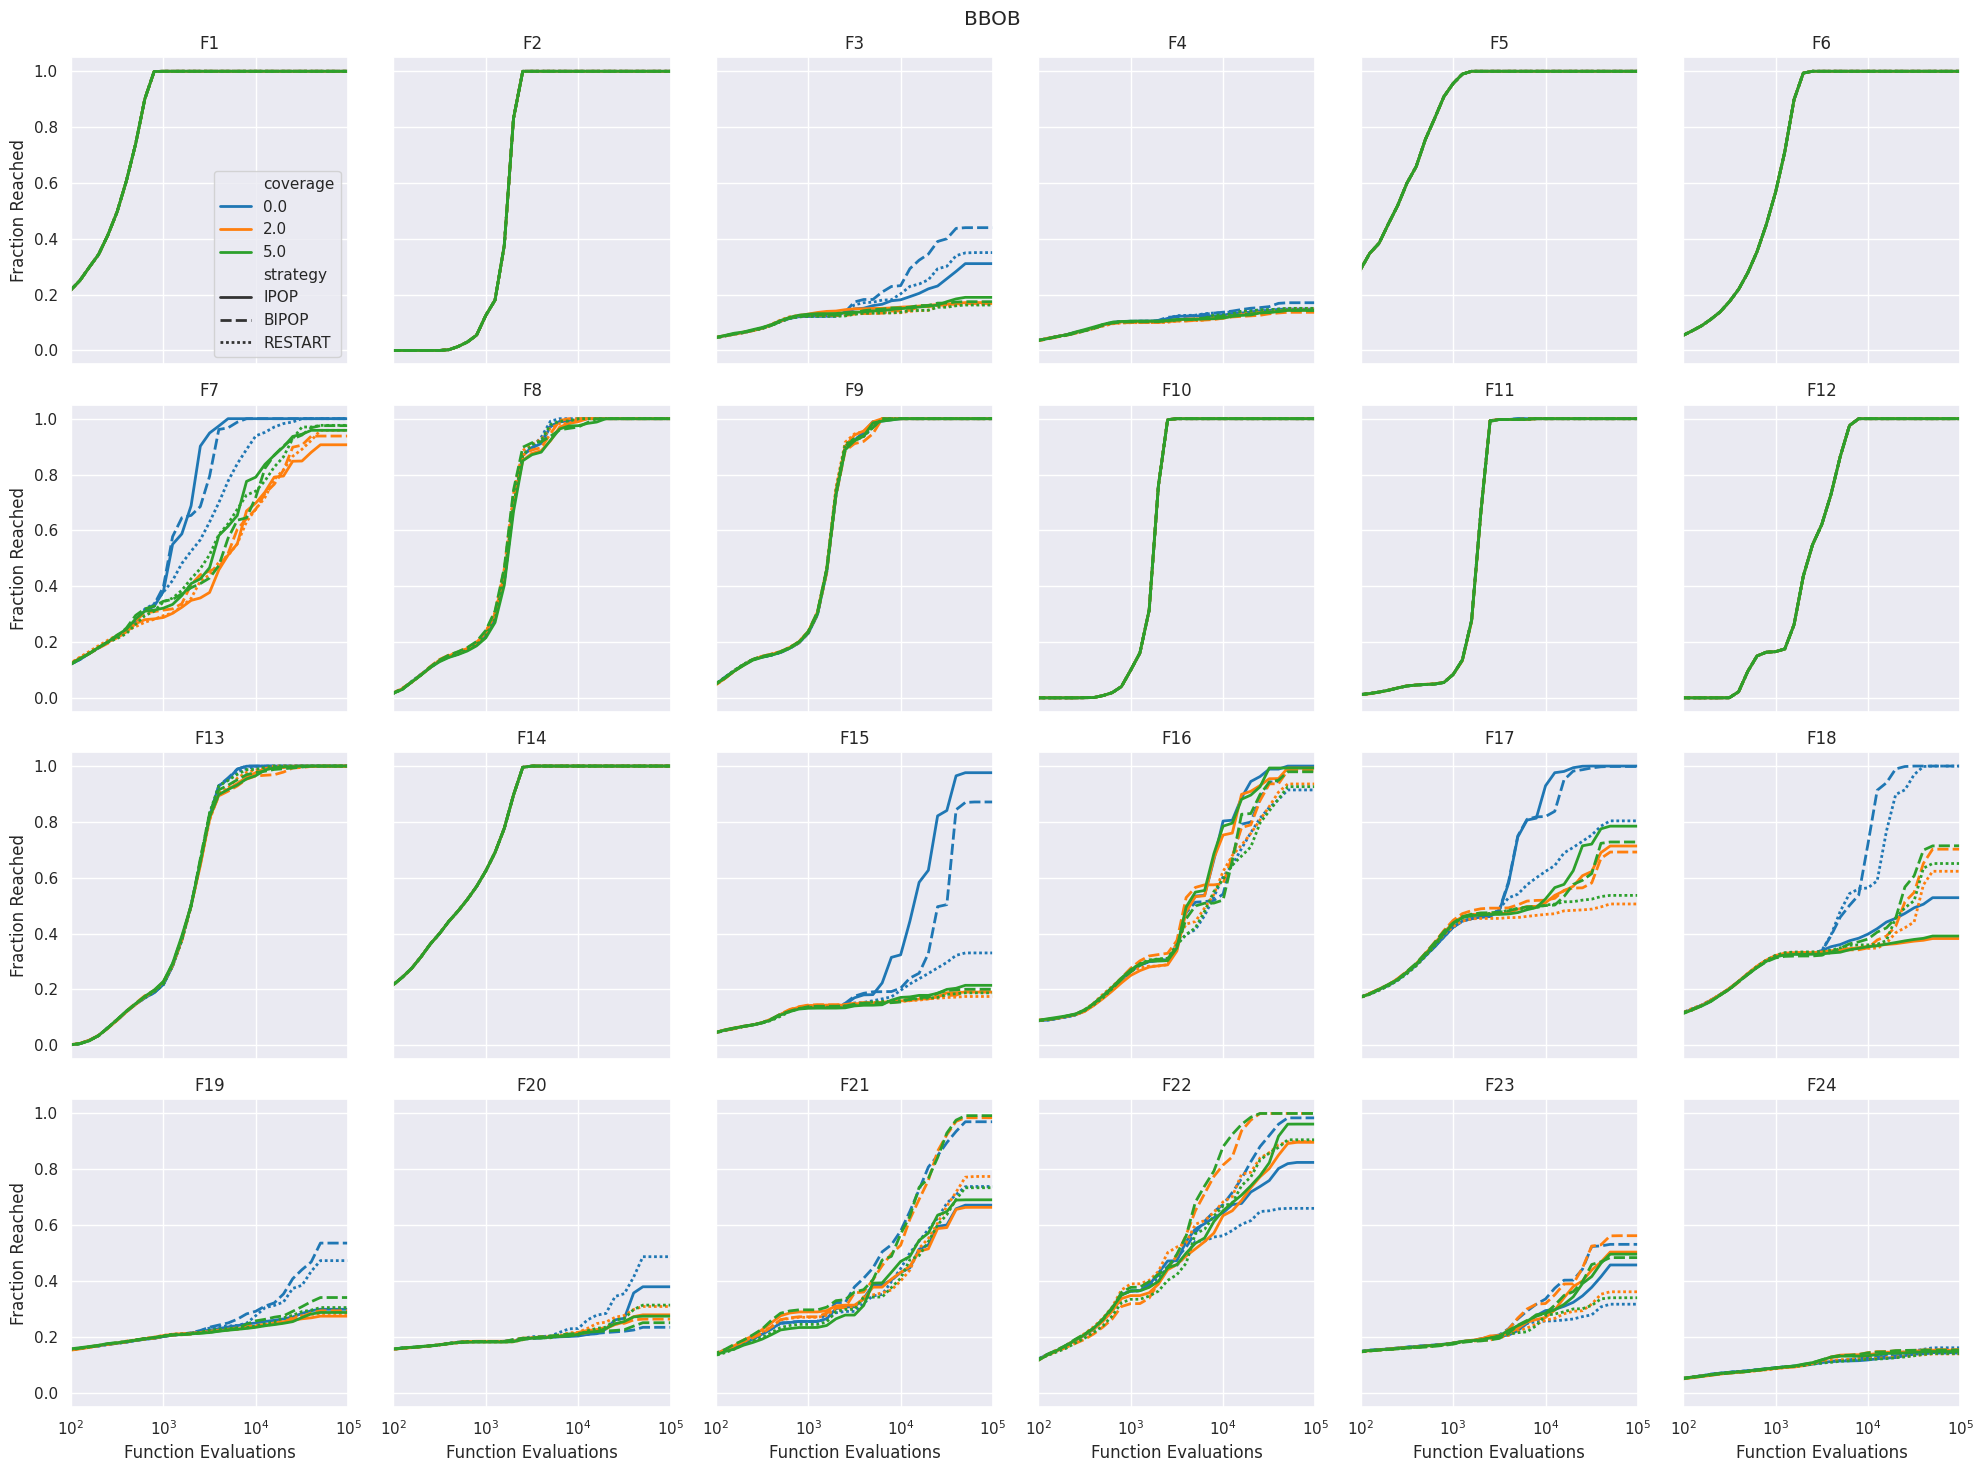

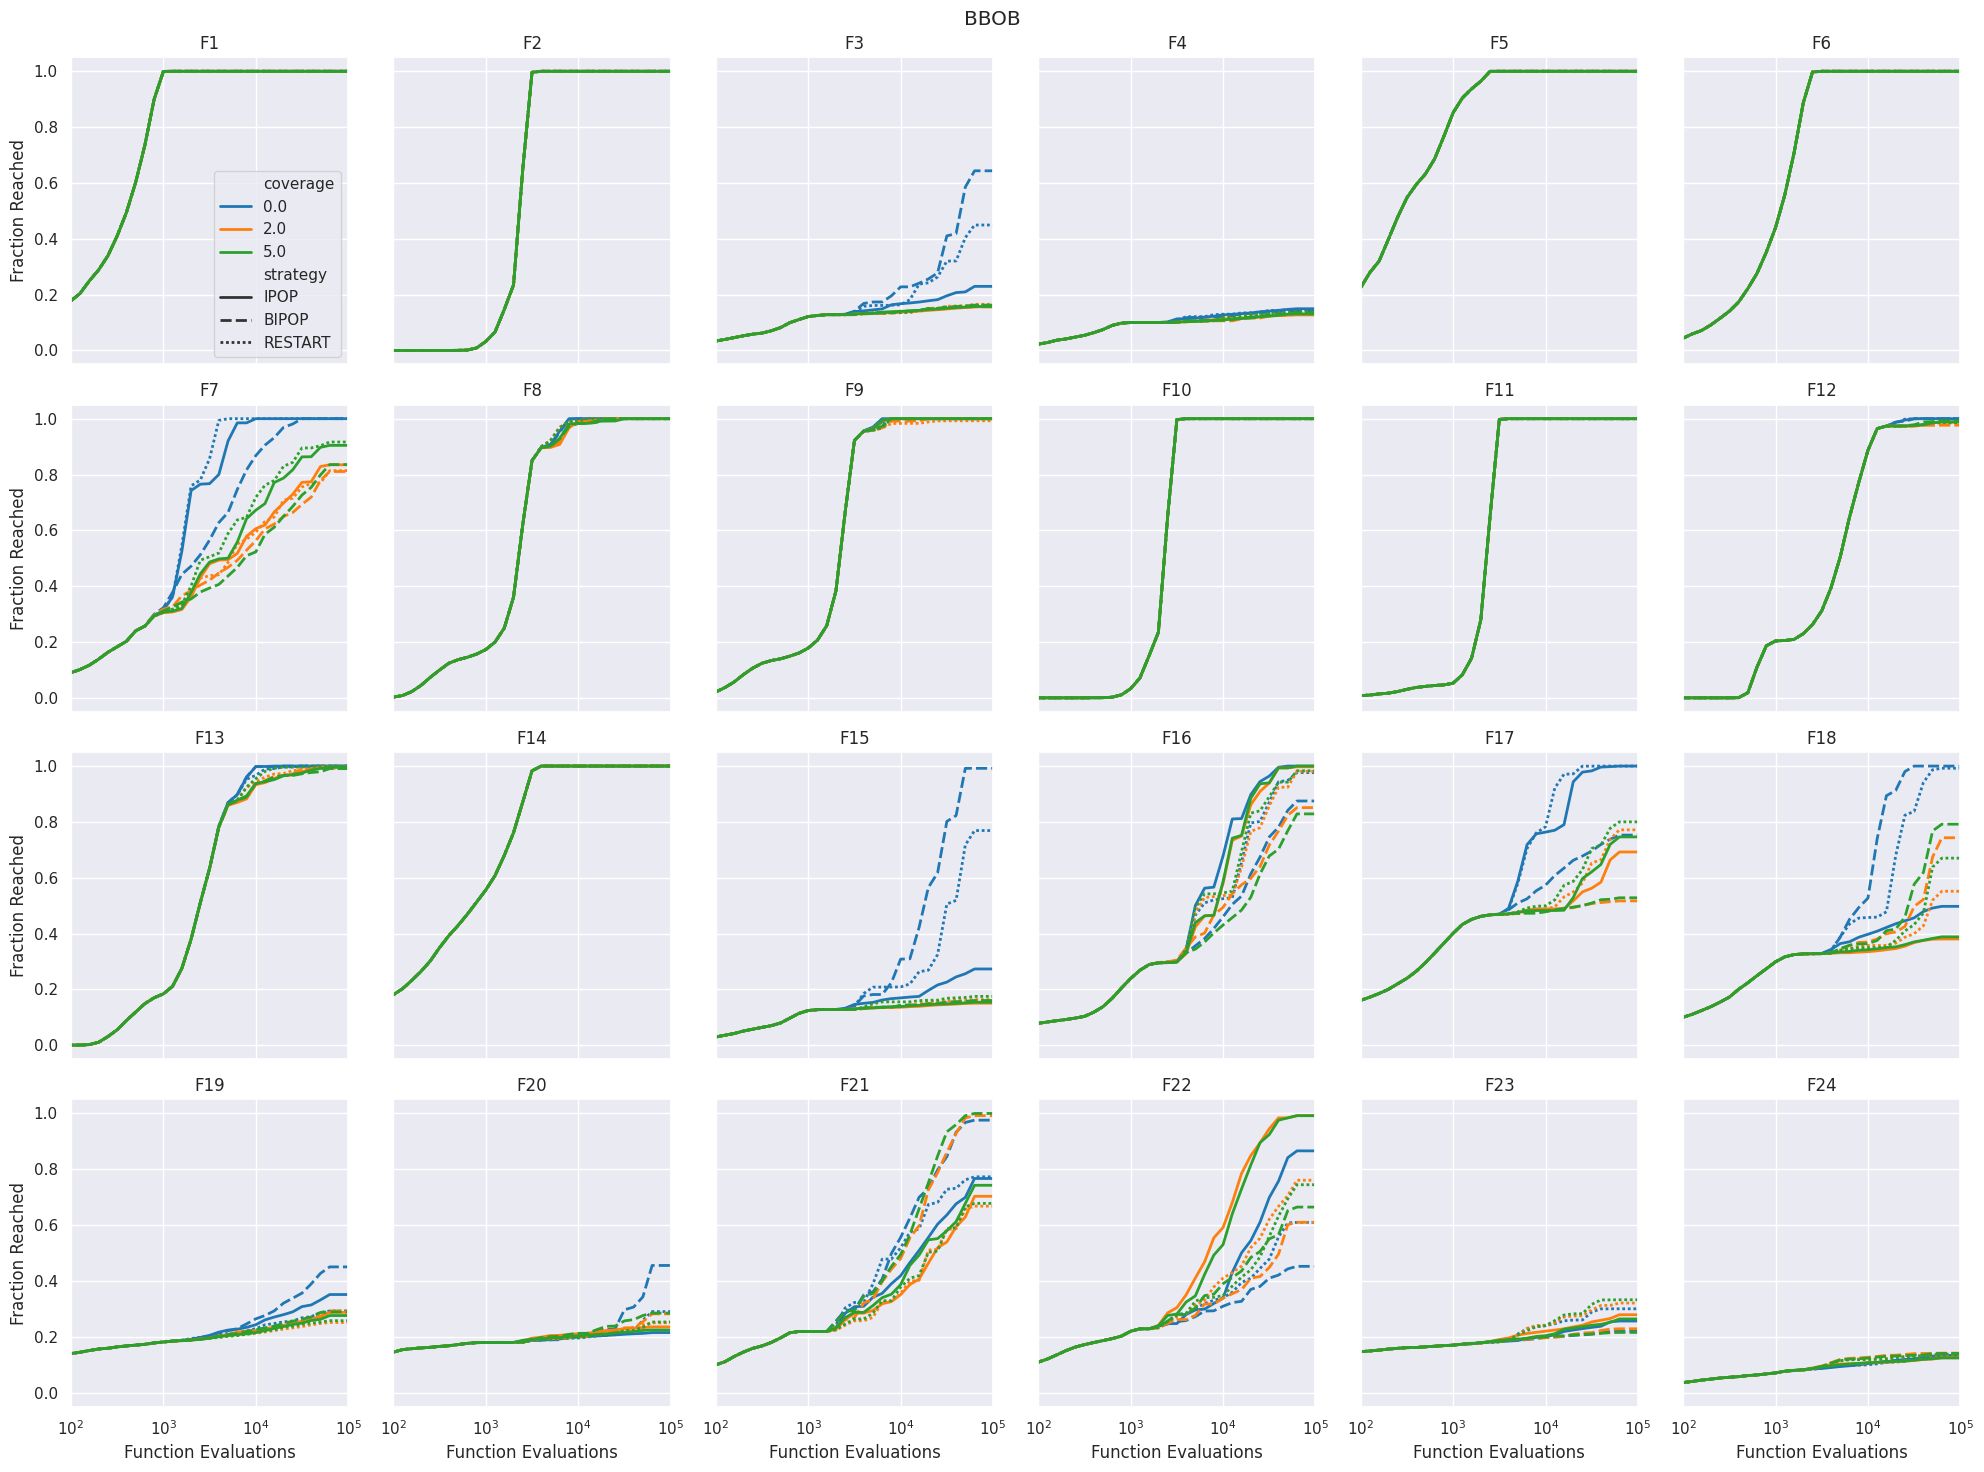

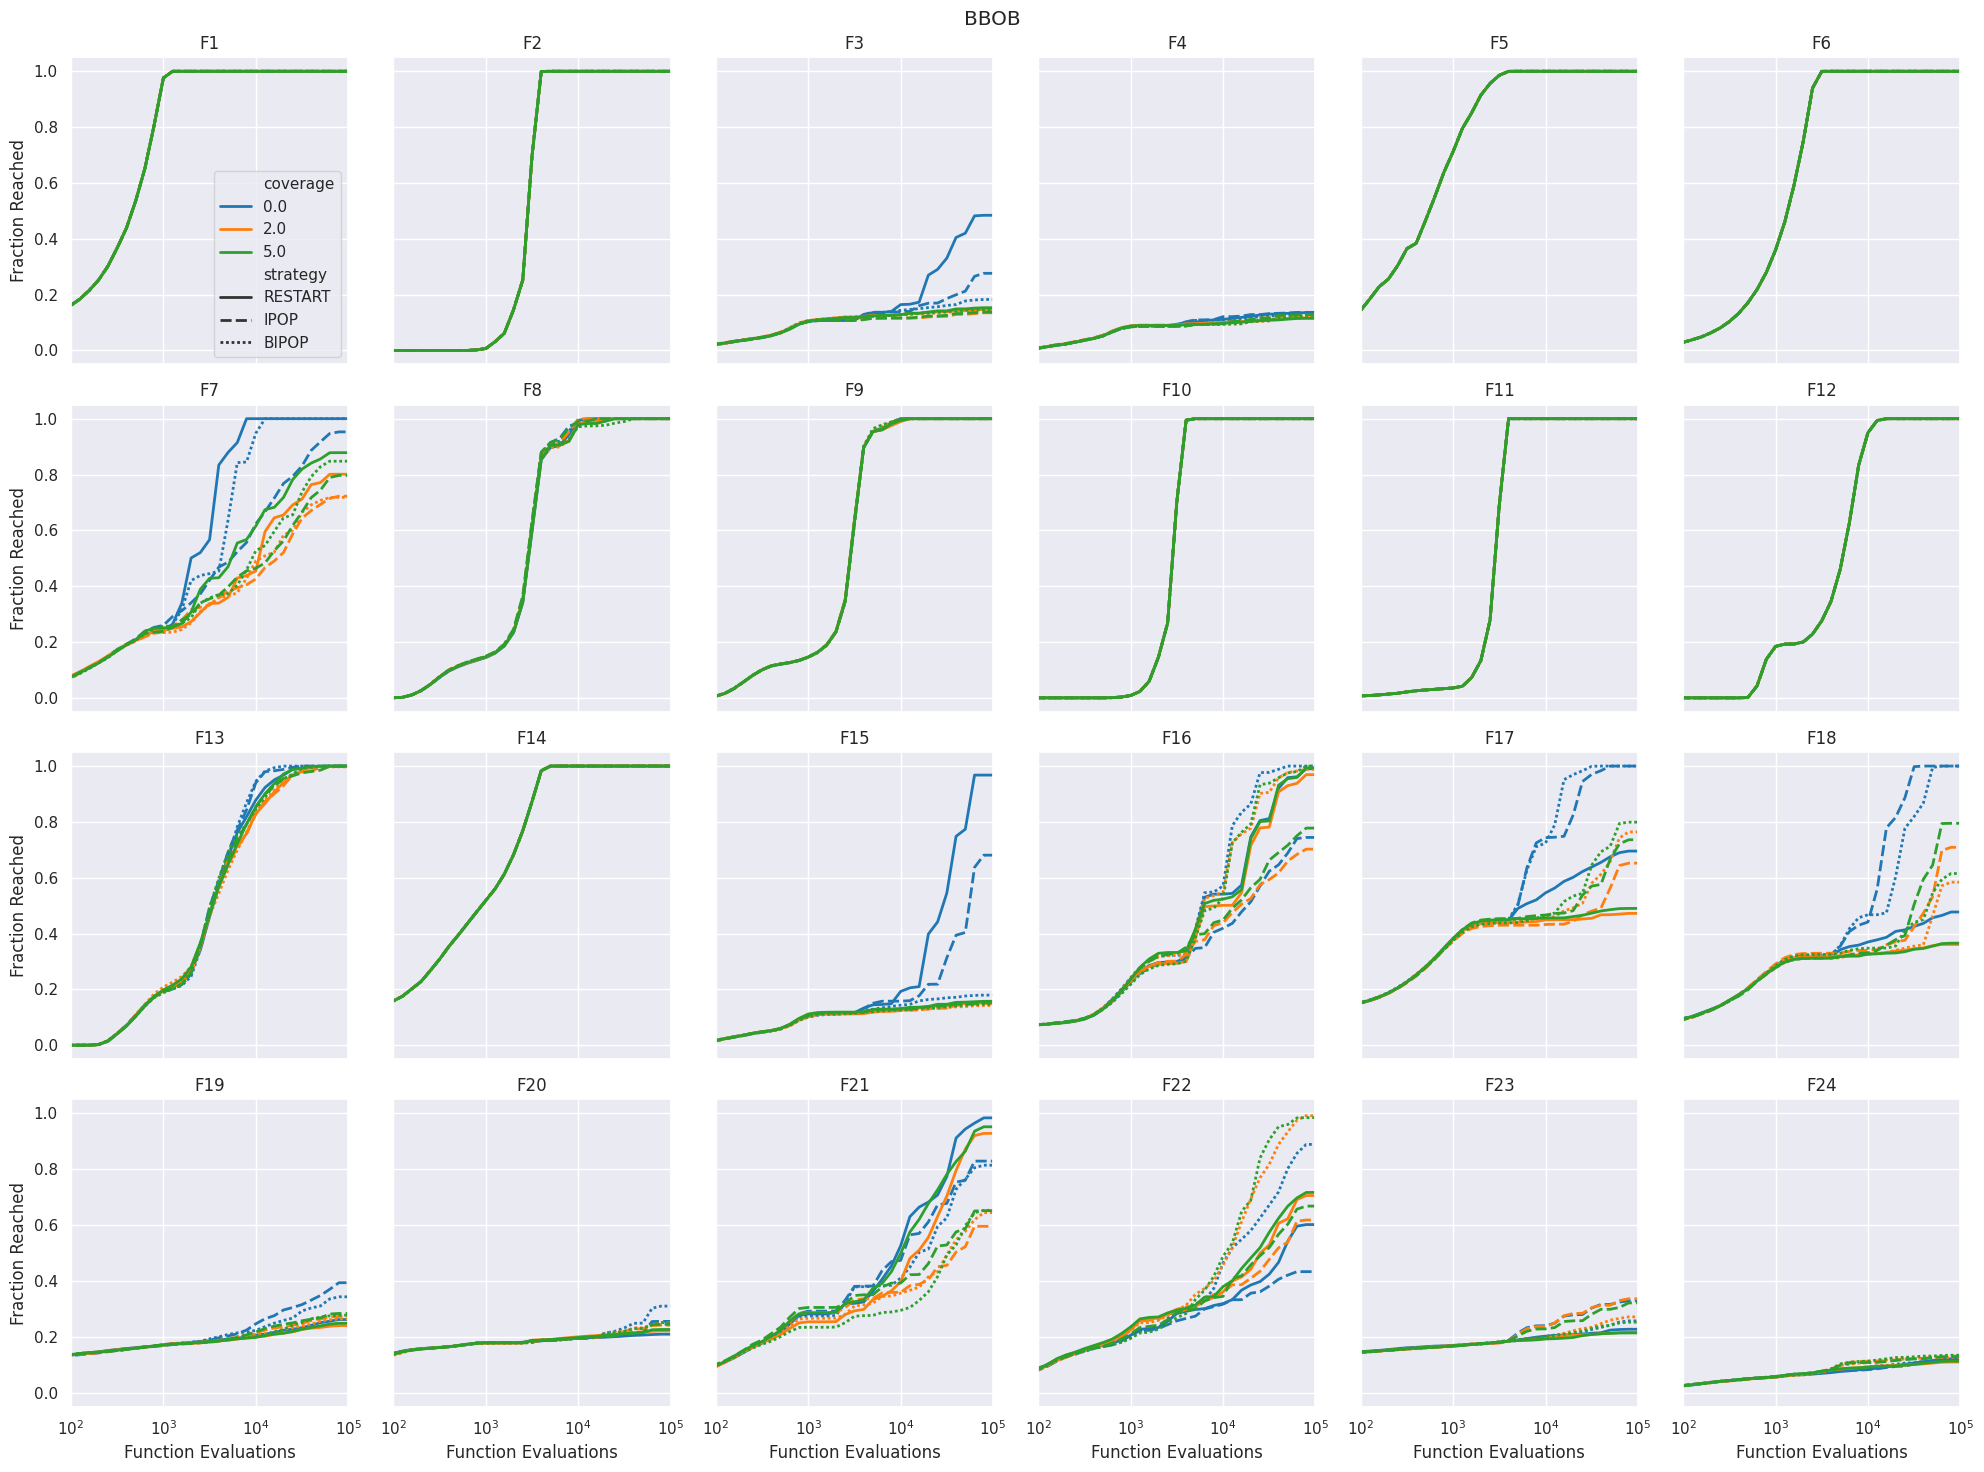

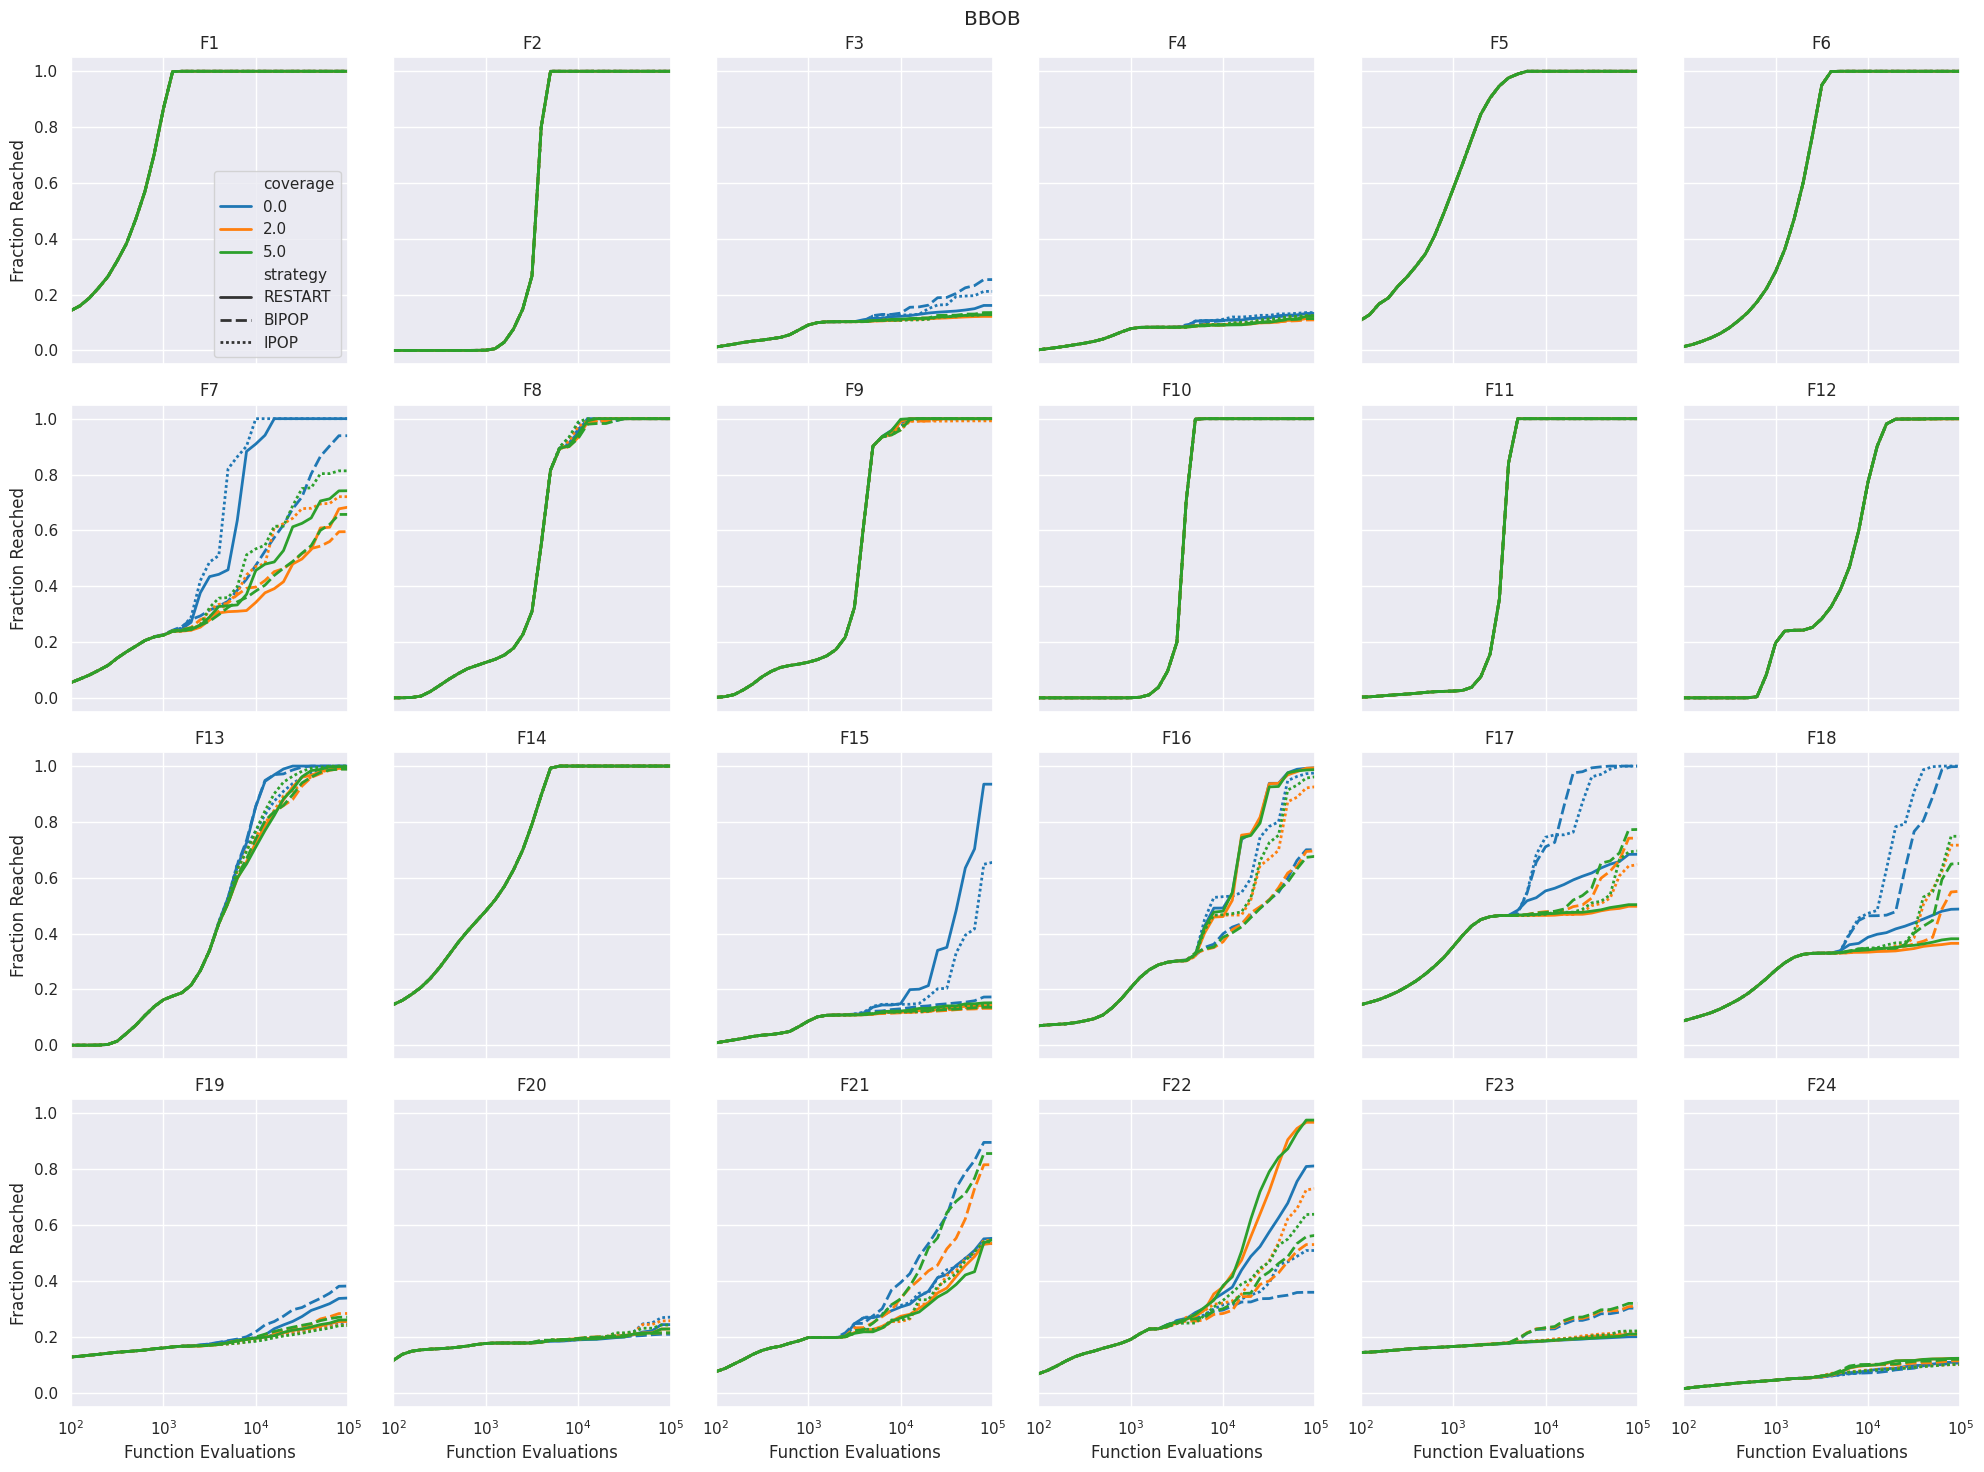

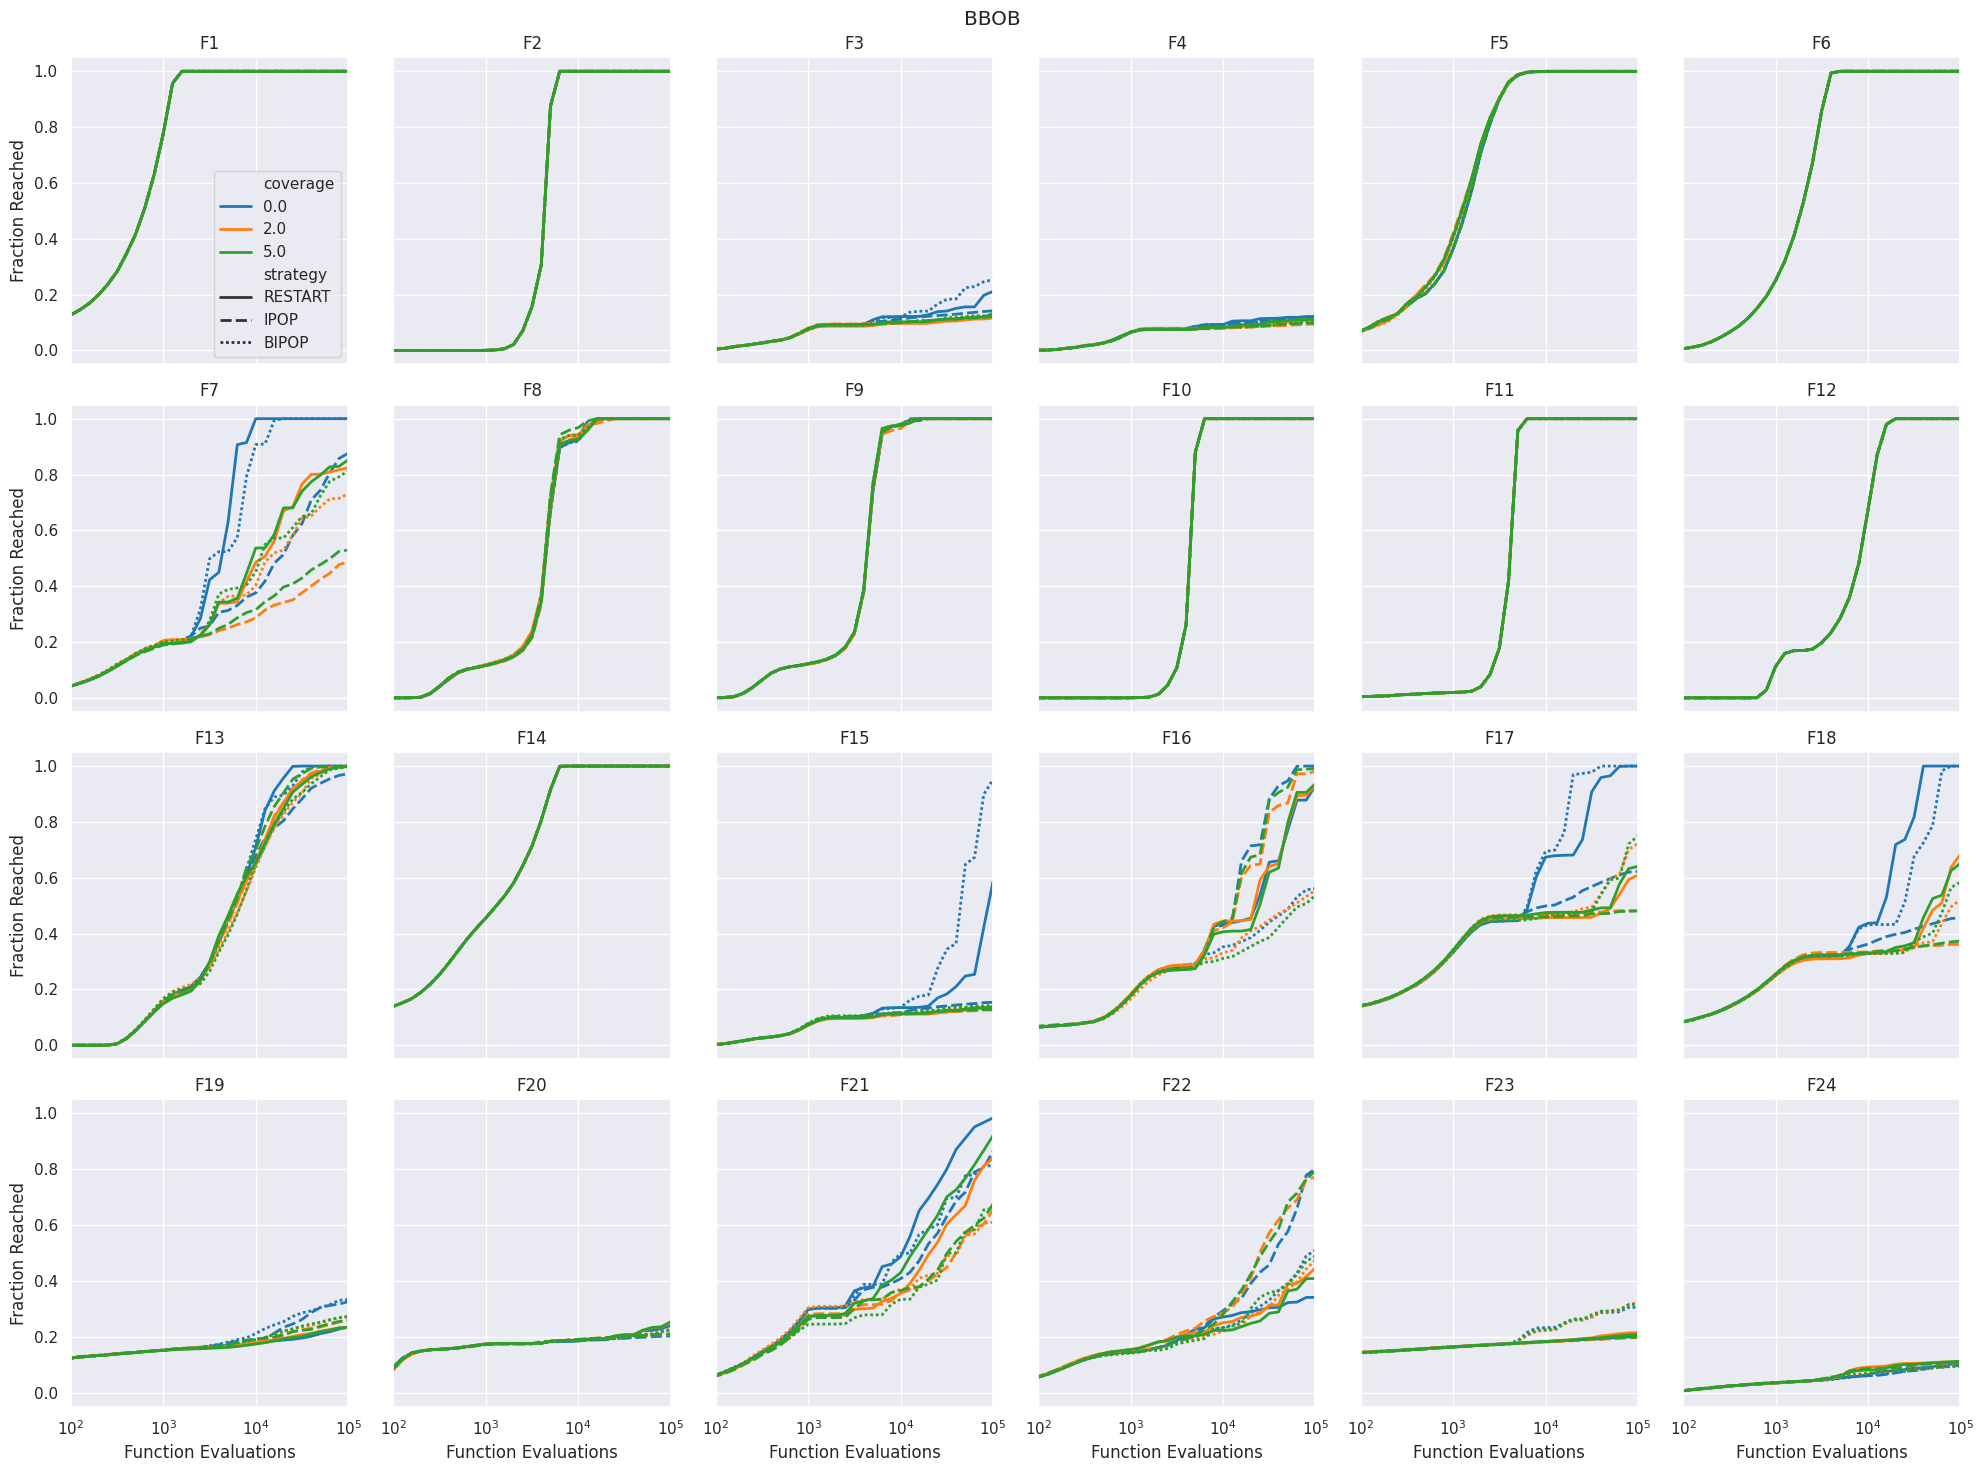

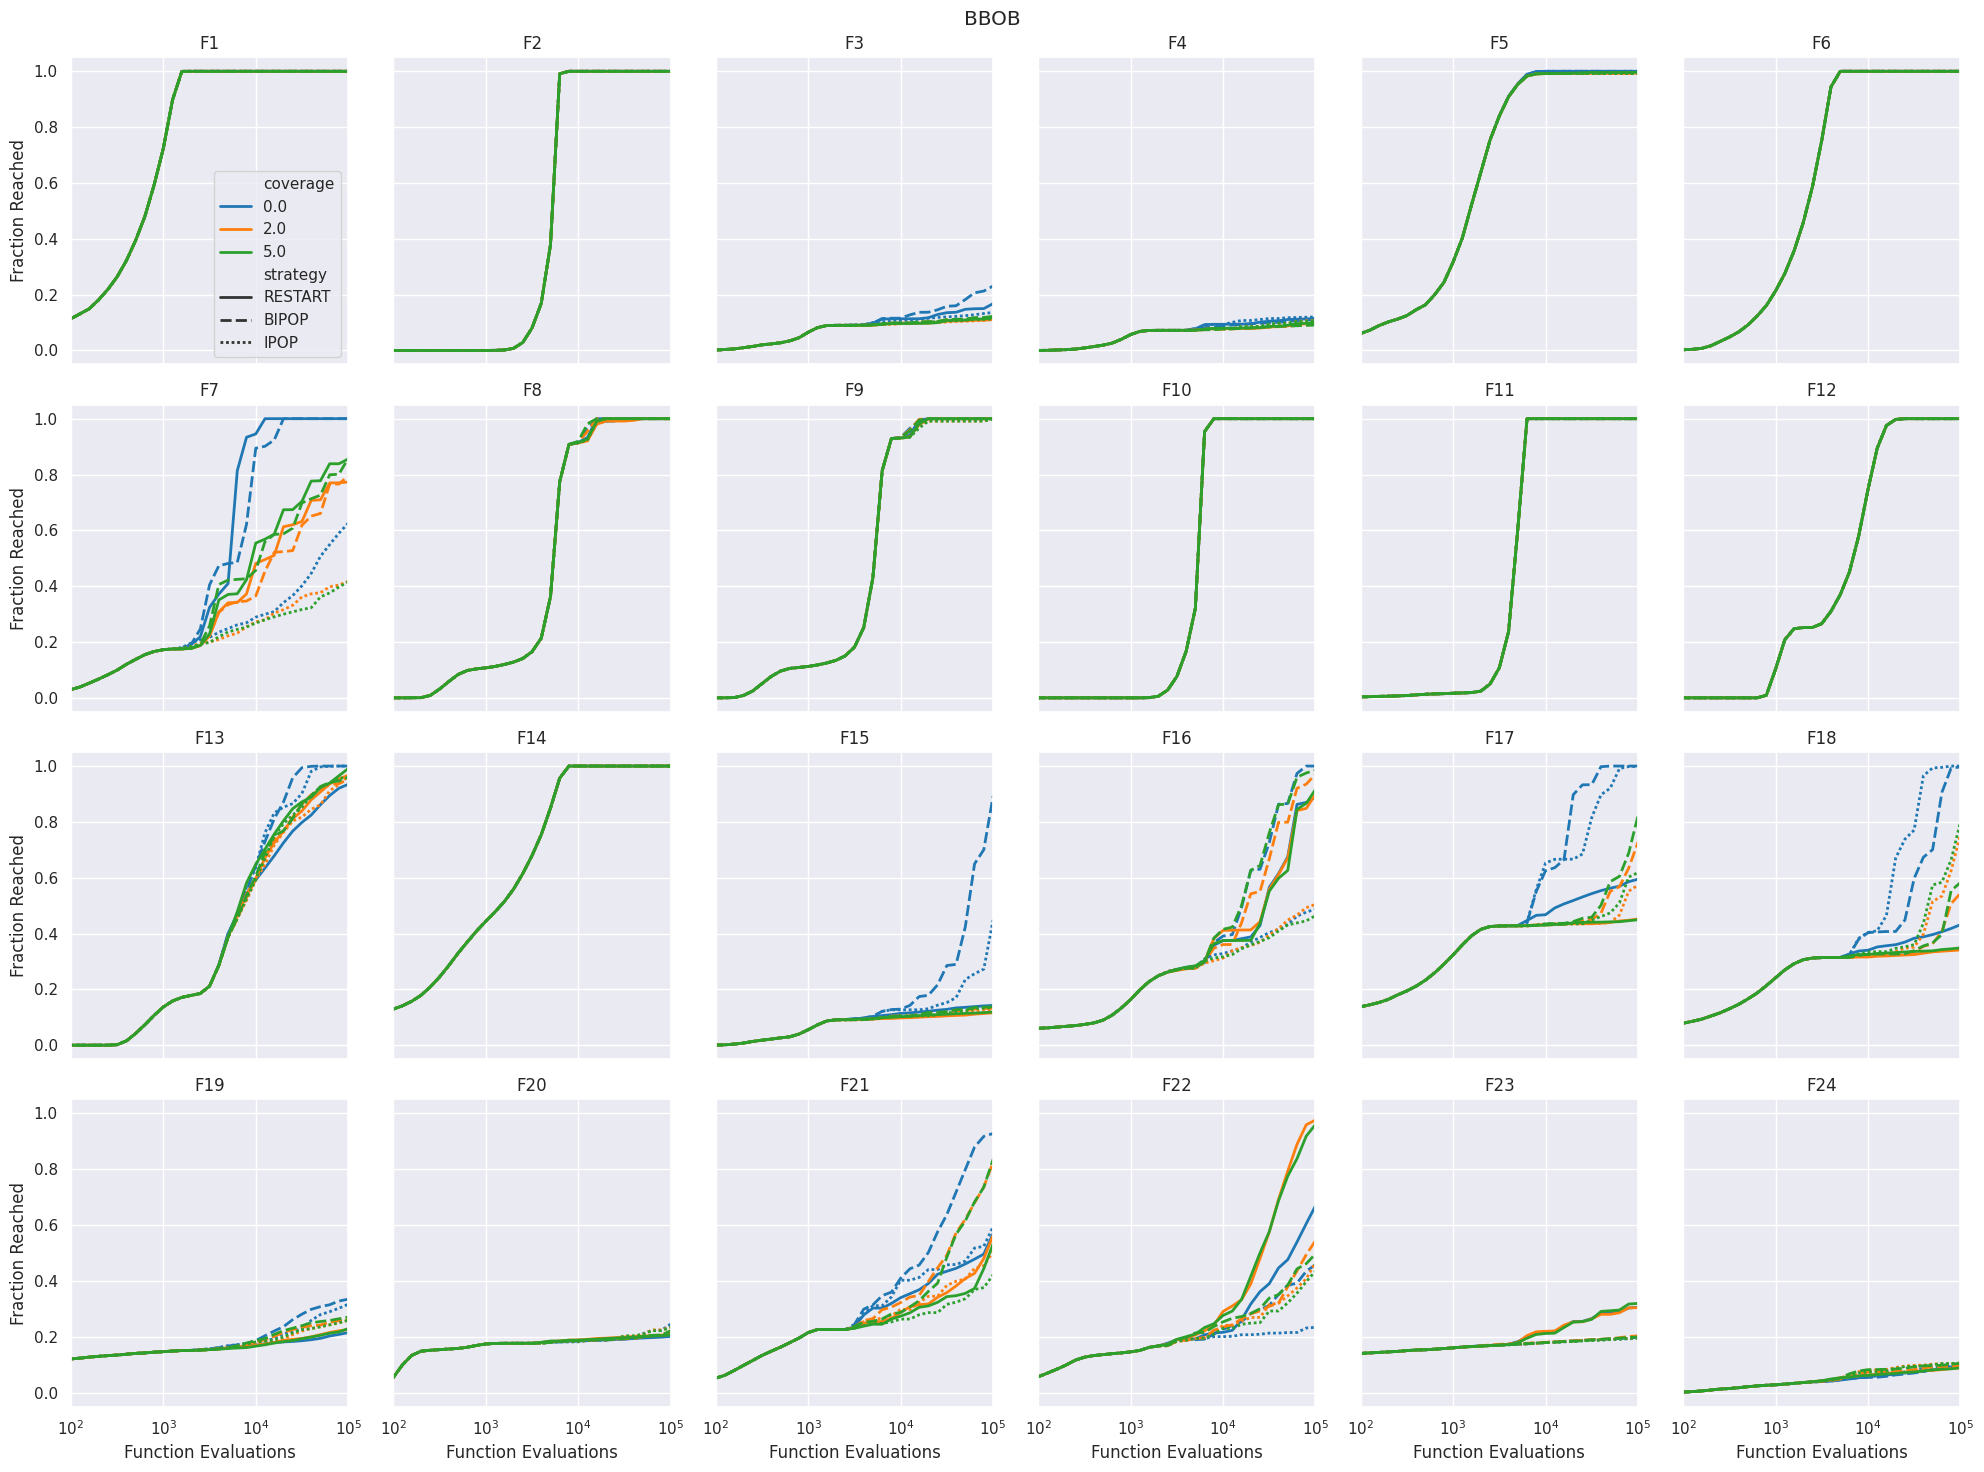

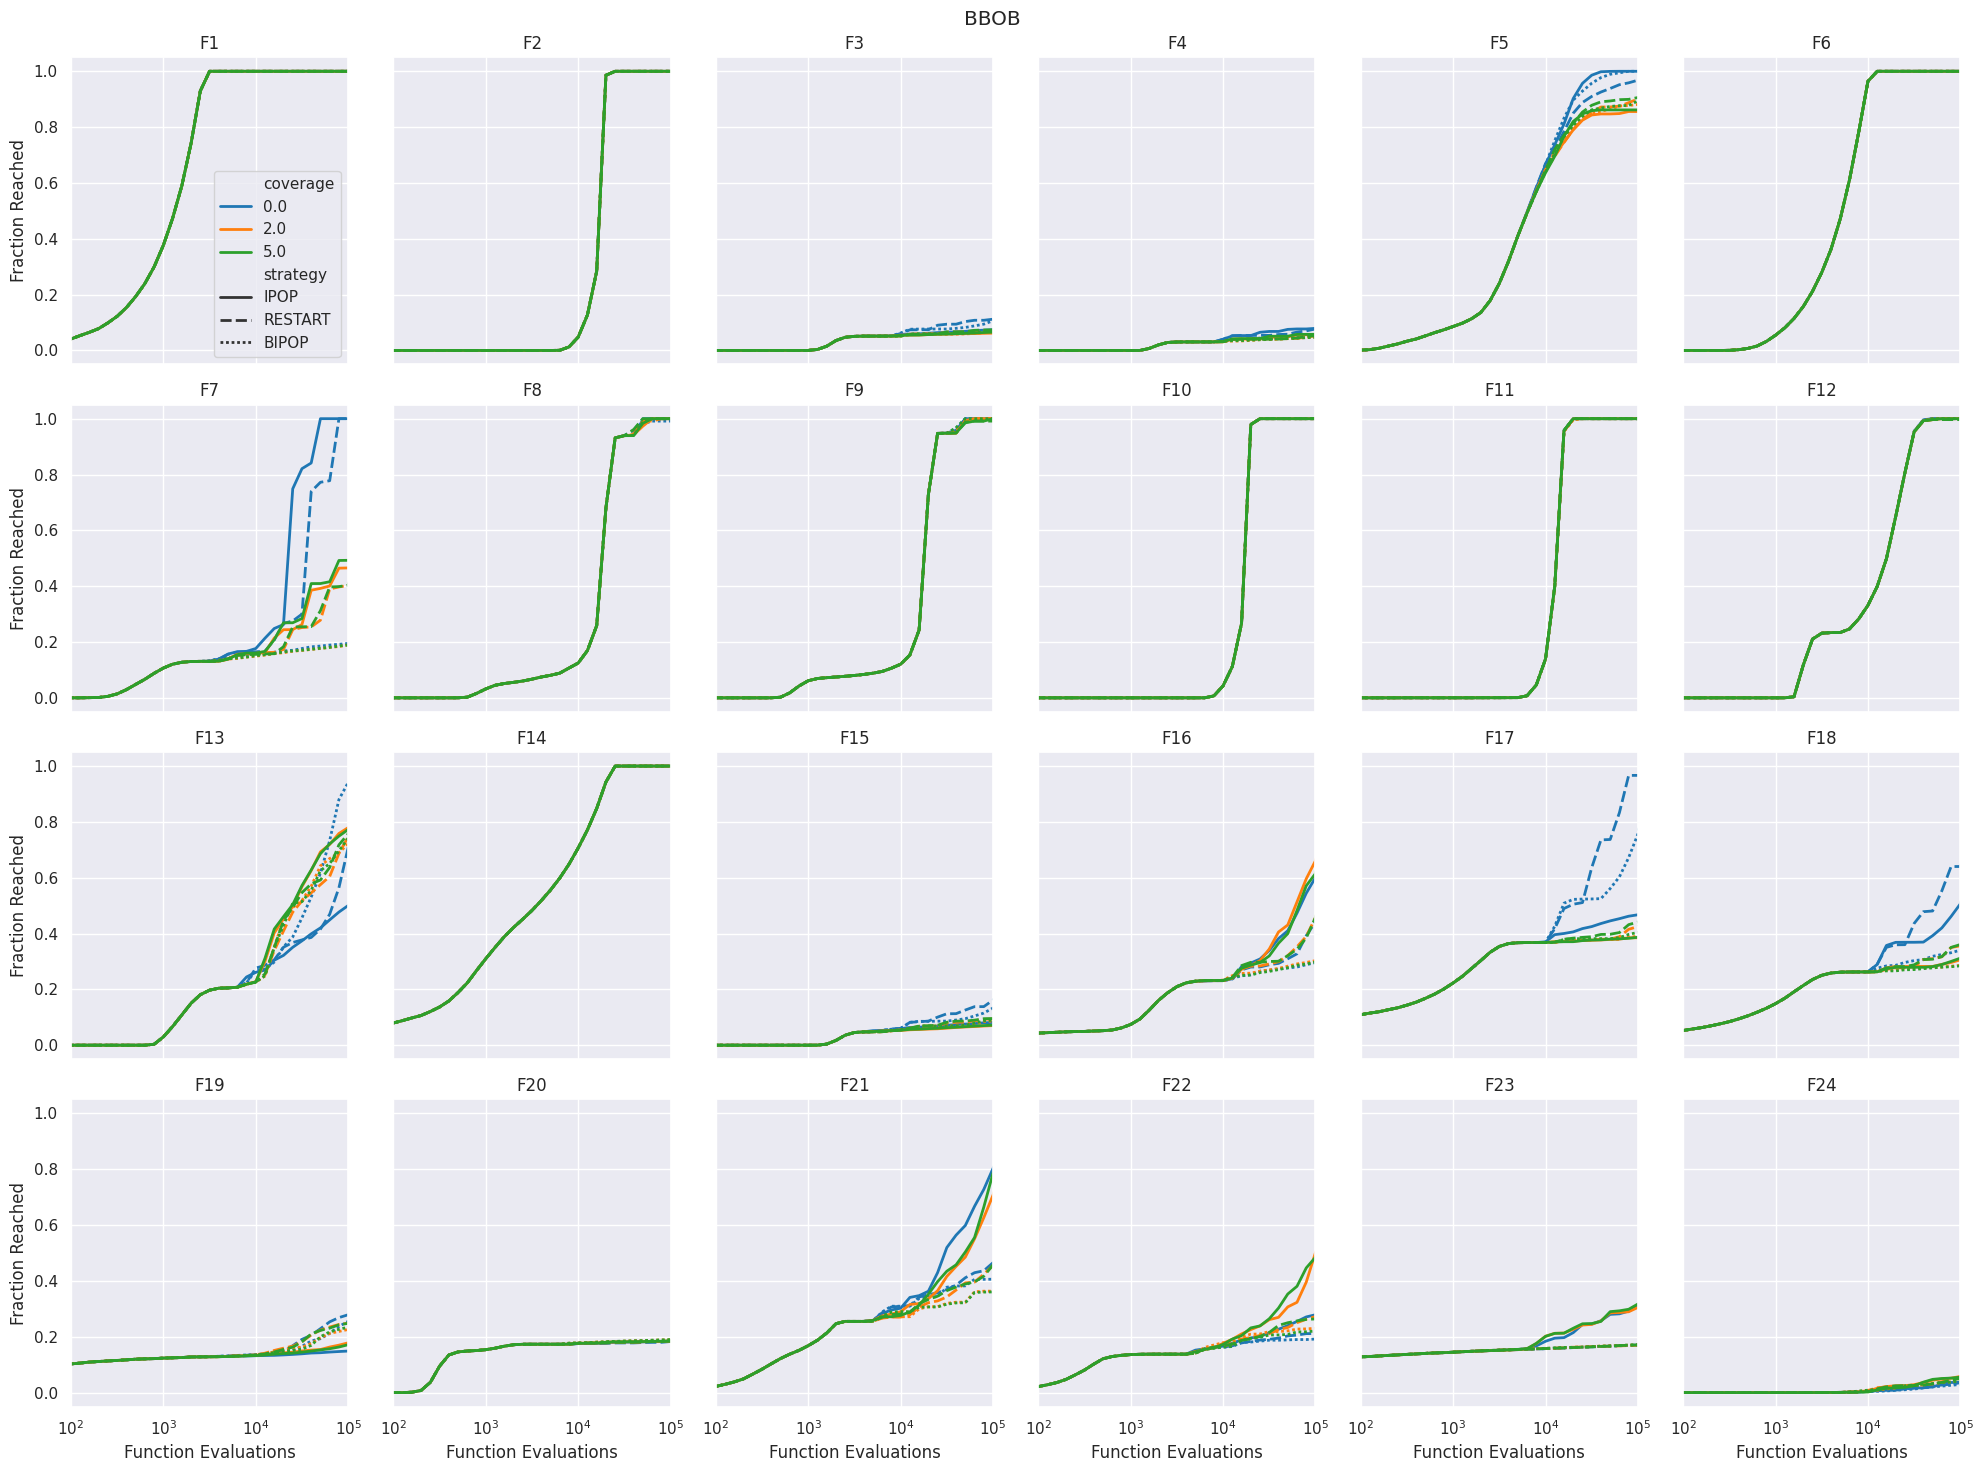

In [51]:
for dim in (2, 3, 4, 5, 6, 7, 8, 9, 10, 20):
    f, axes = plt.subplots(4, 6, figsize=(20, 15), sharey=True, sharex=True)
    f.suptitle("BBOB")
    for fid, ax  in zip(range(1, 25), axes.ravel()):
        sbs.set_theme(style="darkgrid")
        sbs.lineplot(
            data.query(
                f"fid == {fid} & dim == {dim} & coverage < 10 & elitist == False"
            ).sort_values("coverage"),
            x="budget",
            y="ecdf",
            hue="coverage",
            style="strategy", 
            errorbar=None,
            palette='tab10',
            lw=2,
            ax=ax
        )
        ax.set_xscale("log")
        ax.set_title(f"F{fid}")
        ax.set_xlim(1e2, 1e5)
        ax.set_ylabel("Fraction Reached")
        ax.set_xlabel("Function Evaluations")
    
        if fid > 1:
            ax.get_legend().remove()
    
    plt.tight_layout()
    plt.savefig(f"figures/bbob_ecdf_dim_{dim}.pdf")

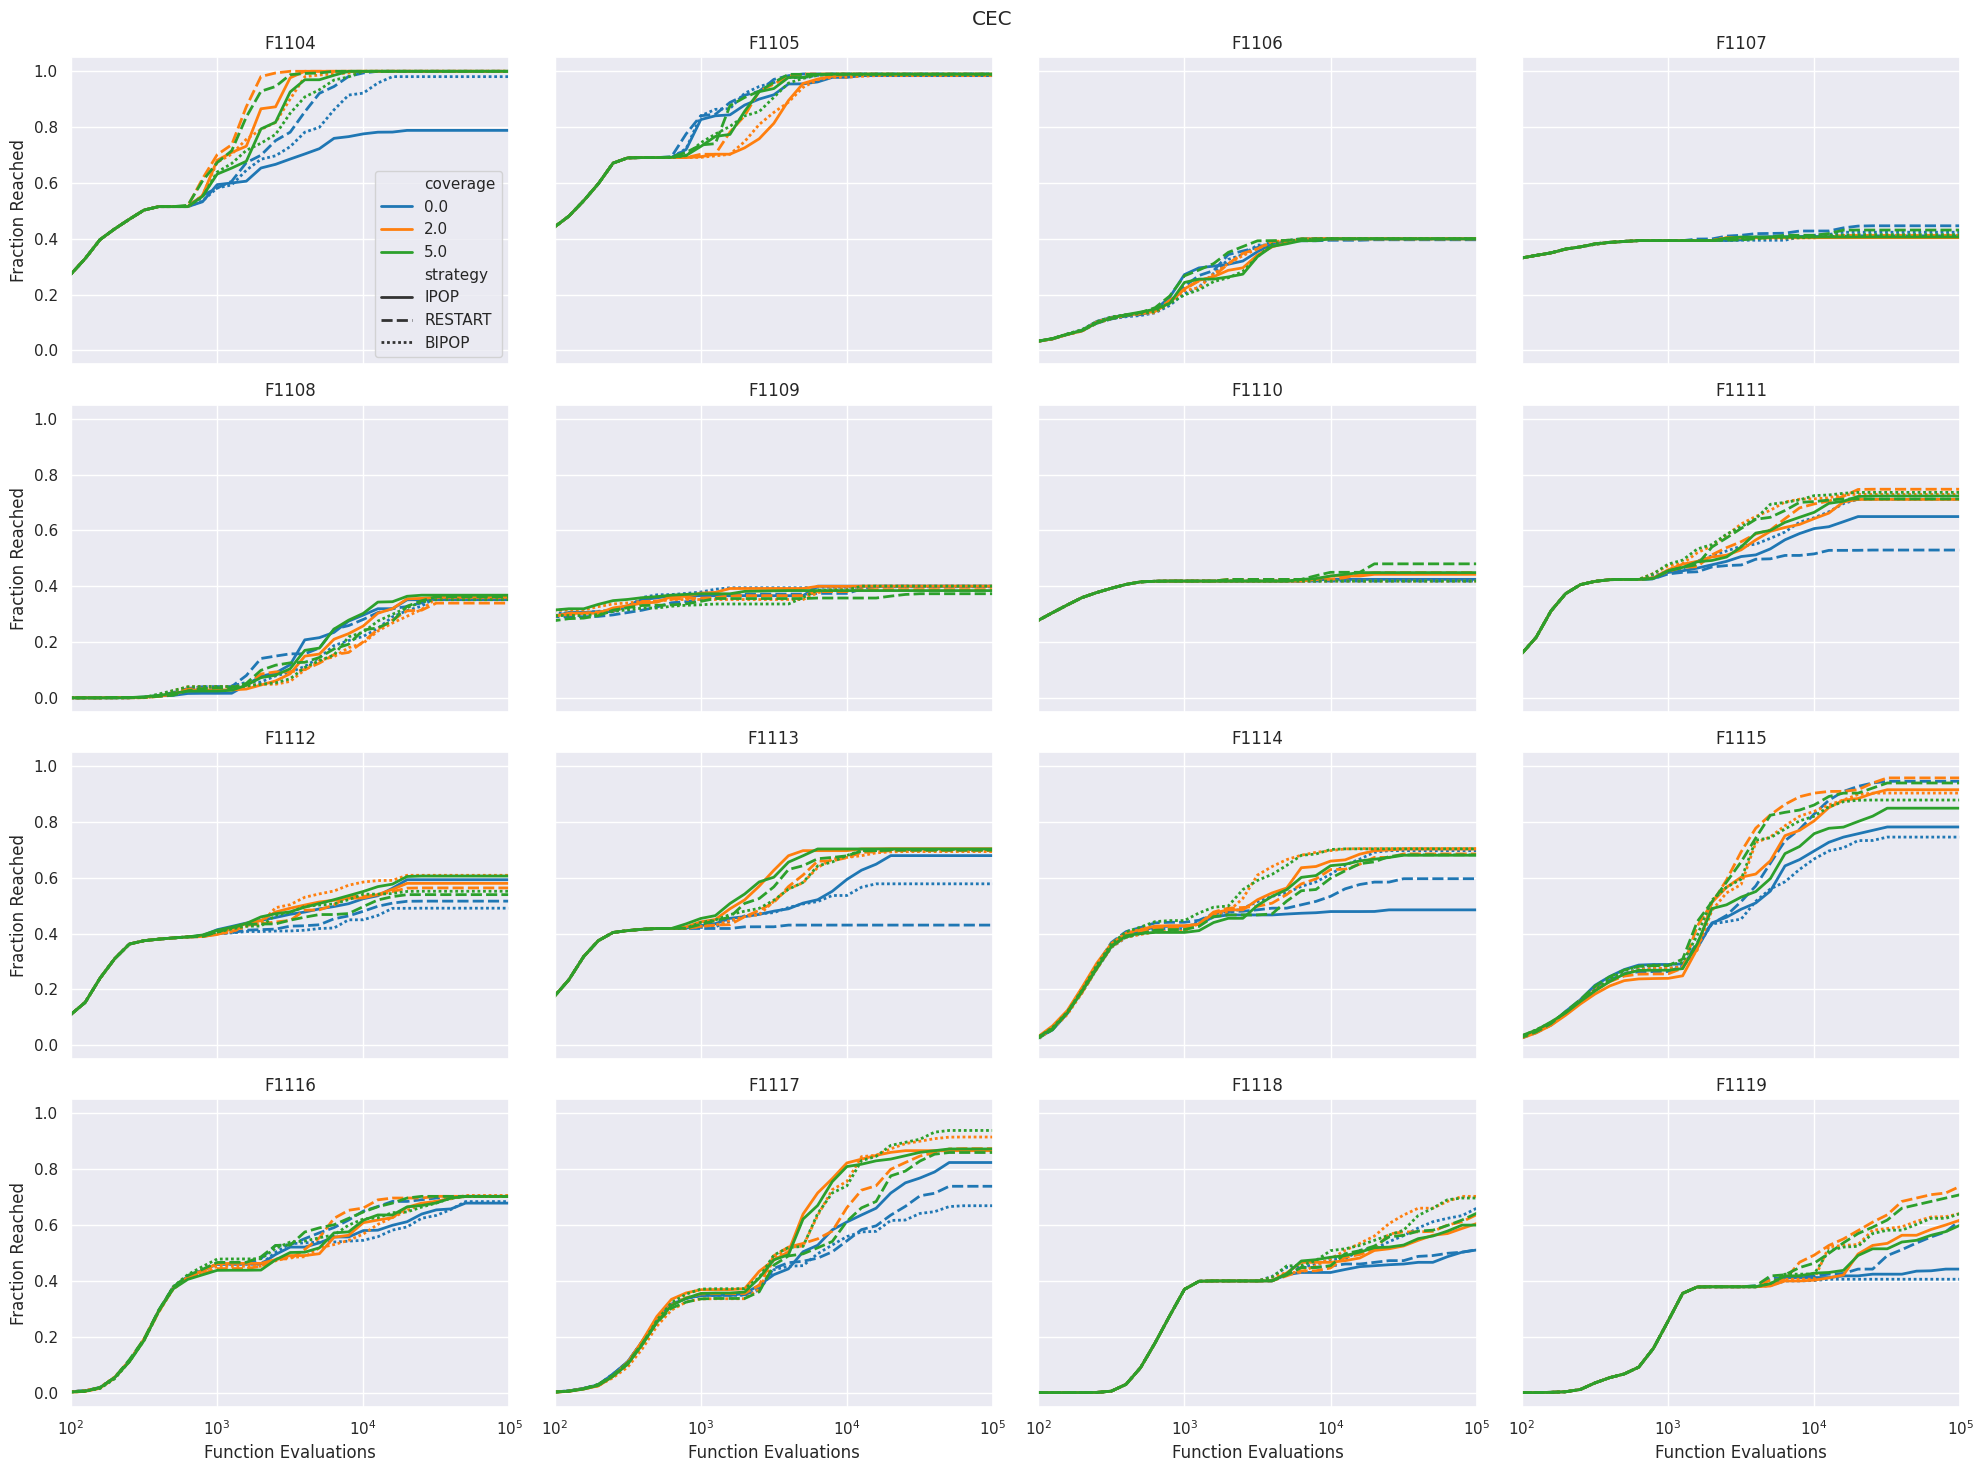

In [49]:
f, axes = plt.subplots(4, 4, figsize=(20, 15), sharey=True, sharex=True)
f.suptitle("CEC")
for fid, ax  in zip(range(1104, 1121), axes.ravel()):
    sbs.set_theme(style="darkgrid")
    sbs.lineplot(
        data.query(
            f"fid == {fid} & coverage < 10 & elitist == False"
        ).sort_values("coverage"),
        x="budget",
        y="ecdf",
        hue="coverage",
        style="strategy", 
        errorbar=None,
        palette='tab10',
        lw=2,
        ax=ax
    )
    ax.set_xscale("log")
    ax.set_title(f"F{fid}")
    ax.set_xlim(1e2, 1e5)
    ax.set_ylabel("Fraction Reached")
    ax.set_xlabel("Function Evaluations")

    if fid > 1104:
        ax.get_legend().remove()

plt.tight_layout()
plt.savefig("figures/cec_ecdf.pdf")

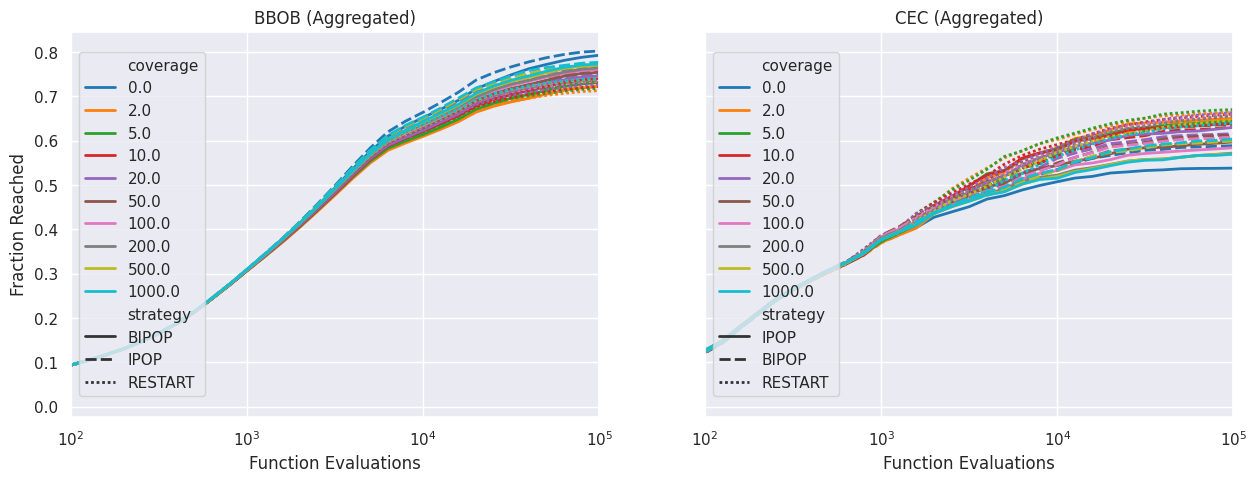

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(15, 5))
sbs.set_theme(style="darkgrid")
sbs.lineplot(
    data.query(
        f"fid < 200 & coverage < 10000 & elitist == False"
    ).sort_values("coverage"),
    x="budget",
    y="ecdf",
    hue="coverage",
    style="strategy", 
    errorbar=None,
    palette='tab10',
    lw=2,
    ax=ax1
)
sbs.set_theme(style="darkgrid")
sbs.lineplot(
    data.query(
        f"fid > 200 & coverage < 10000 & elitist == False"
    ).sort_values("coverage"),
    x="budget",
    y="ecdf",
    hue="coverage",
    style="strategy", 
    errorbar=None,
    palette='tab10',
    lw=2,
    ax=ax2
)
for ax in (ax1, ax2):
    sbs.move_legend(ax, "center left")
    ax.set_xscale("log")
    ax.set_xlim(1e2, 1e5)
    ax.set_ylabel("Fraction Reached")
    ax.set_xlabel("Function Evaluations")
ax1.set_title(f"BBOB (Aggregated)")
ax2.set_title(f"CEC (Aggregated)")
plt.savefig("figures/aggregated_ecdf_low_cov.pdf")

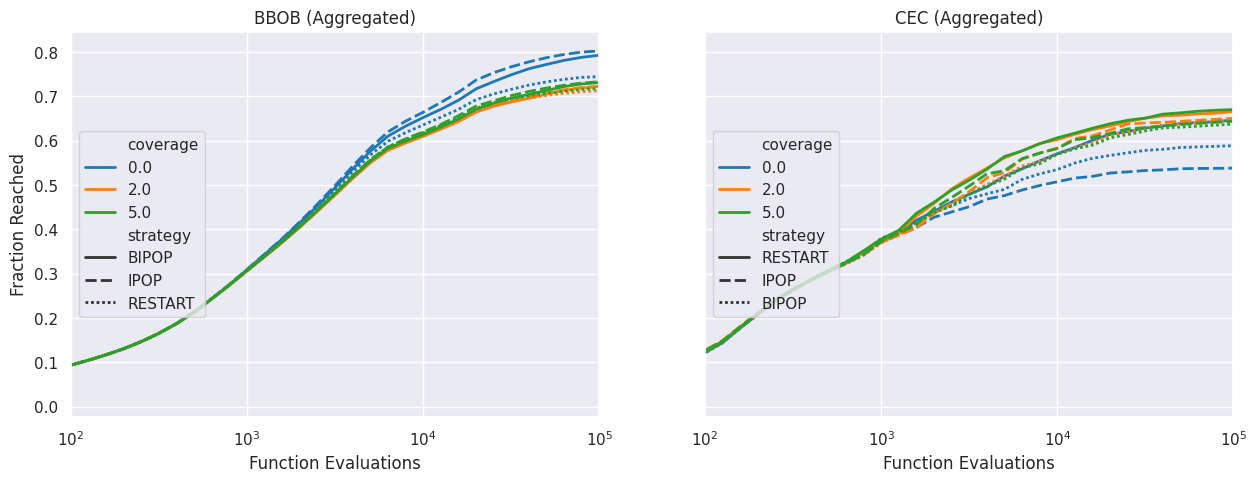

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(15, 5))
sbs.set_theme(style="darkgrid")
sbs.lineplot(
    data.query(
        f"fid < 200 & coverage < 10 & elitist == False"
    ).sort_values("coverage"),
    x="budget",
    y="ecdf",
    hue="coverage",
    style="strategy", 
    errorbar=None,
    palette='tab10',
    lw=2,
    ax=ax1
)
sbs.set_theme(style="darkgrid")
sbs.lineplot(
    data.query(
        f"fid > 200 & coverage < 10 & elitist == False"
    ).sort_values("coverage"),
    x="budget",
    y="ecdf",
    hue="coverage",
    style="strategy", 
    errorbar=None,
    palette='tab10',
    lw=2,
    ax=ax2
)
for ax in (ax1, ax2):
    sbs.move_legend(ax, "center left")
    ax.set_xscale("log")
    ax.set_xlim(1e2, 1e5)
    ax.set_ylabel("Fraction Reached")
    ax.set_xlabel("Function Evaluations")
ax1.set_title(f"BBOB (Aggregated)")
ax2.set_title(f"CEC (Aggregated)")
plt.savefig("figures/aggregated_ecdf_low_cov.pdf")

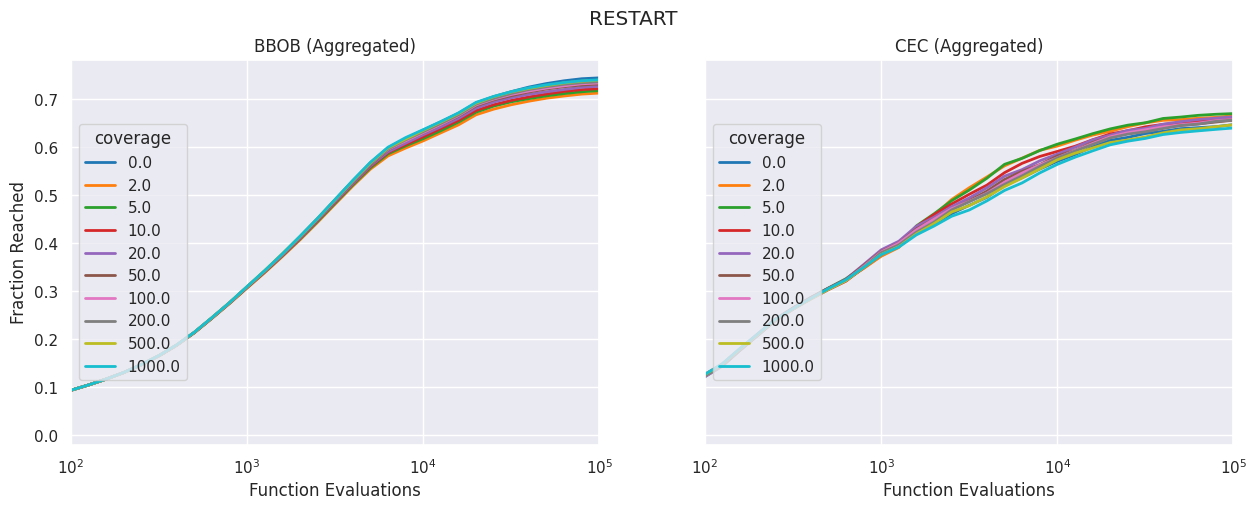

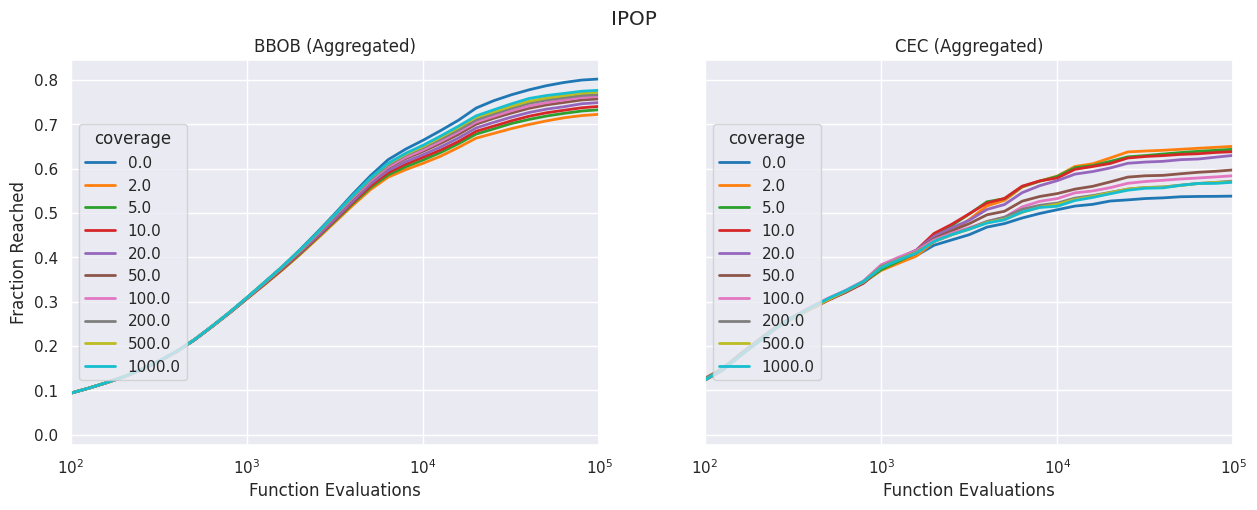

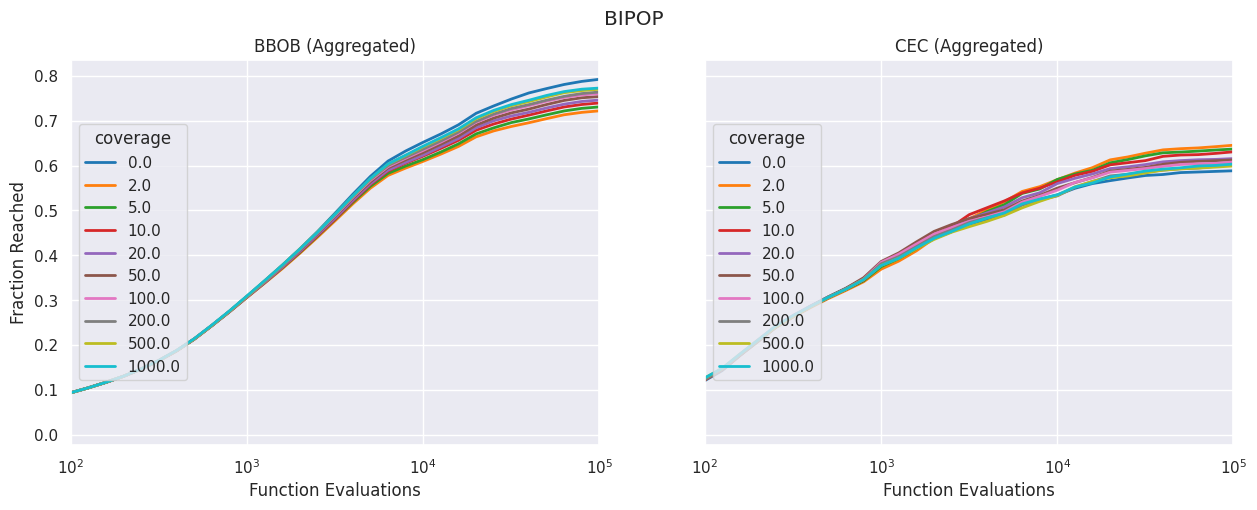

In [20]:
for method in ("RESTART", "IPOP", "BIPOP"):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(15, 5))
    f.suptitle(method)
    sbs.set_theme(style="darkgrid")
    sbs.lineplot(
        data.query(
            f"fid < 200 & coverage < 10000 & elitist == False & strategy == '{method}'"
        ).sort_values("coverage"),
        x="budget",
        y="ecdf",
        hue="coverage",
        errorbar=None,
        palette='tab10',
        lw=2,
        ax=ax1
    )
    sbs.set_theme(style="darkgrid")
    sbs.lineplot(
        data.query(
            f"fid > 200 & coverage < 10000 & elitist == False & strategy == '{method}'"
        ).sort_values("coverage"),
        x="budget",
        y="ecdf",
        hue="coverage",
        errorbar=None,
        palette='tab10',
        lw=2,
        ax=ax2
    )
    for ax in (ax1, ax2):
        sbs.move_legend(ax, "center left")
        ax.set_xscale("log")
        ax.set_xlim(1e2, 1e5)
        ax.set_ylabel("Fraction Reached")
        ax.set_xlabel("Function Evaluations")
    ax1.set_title(f"BBOB (Aggregated)")
    ax2.set_title(f"CEC (Aggregated)")
    plt.savefig(f"figures/aggregated_ecdf_{method}.pdf")

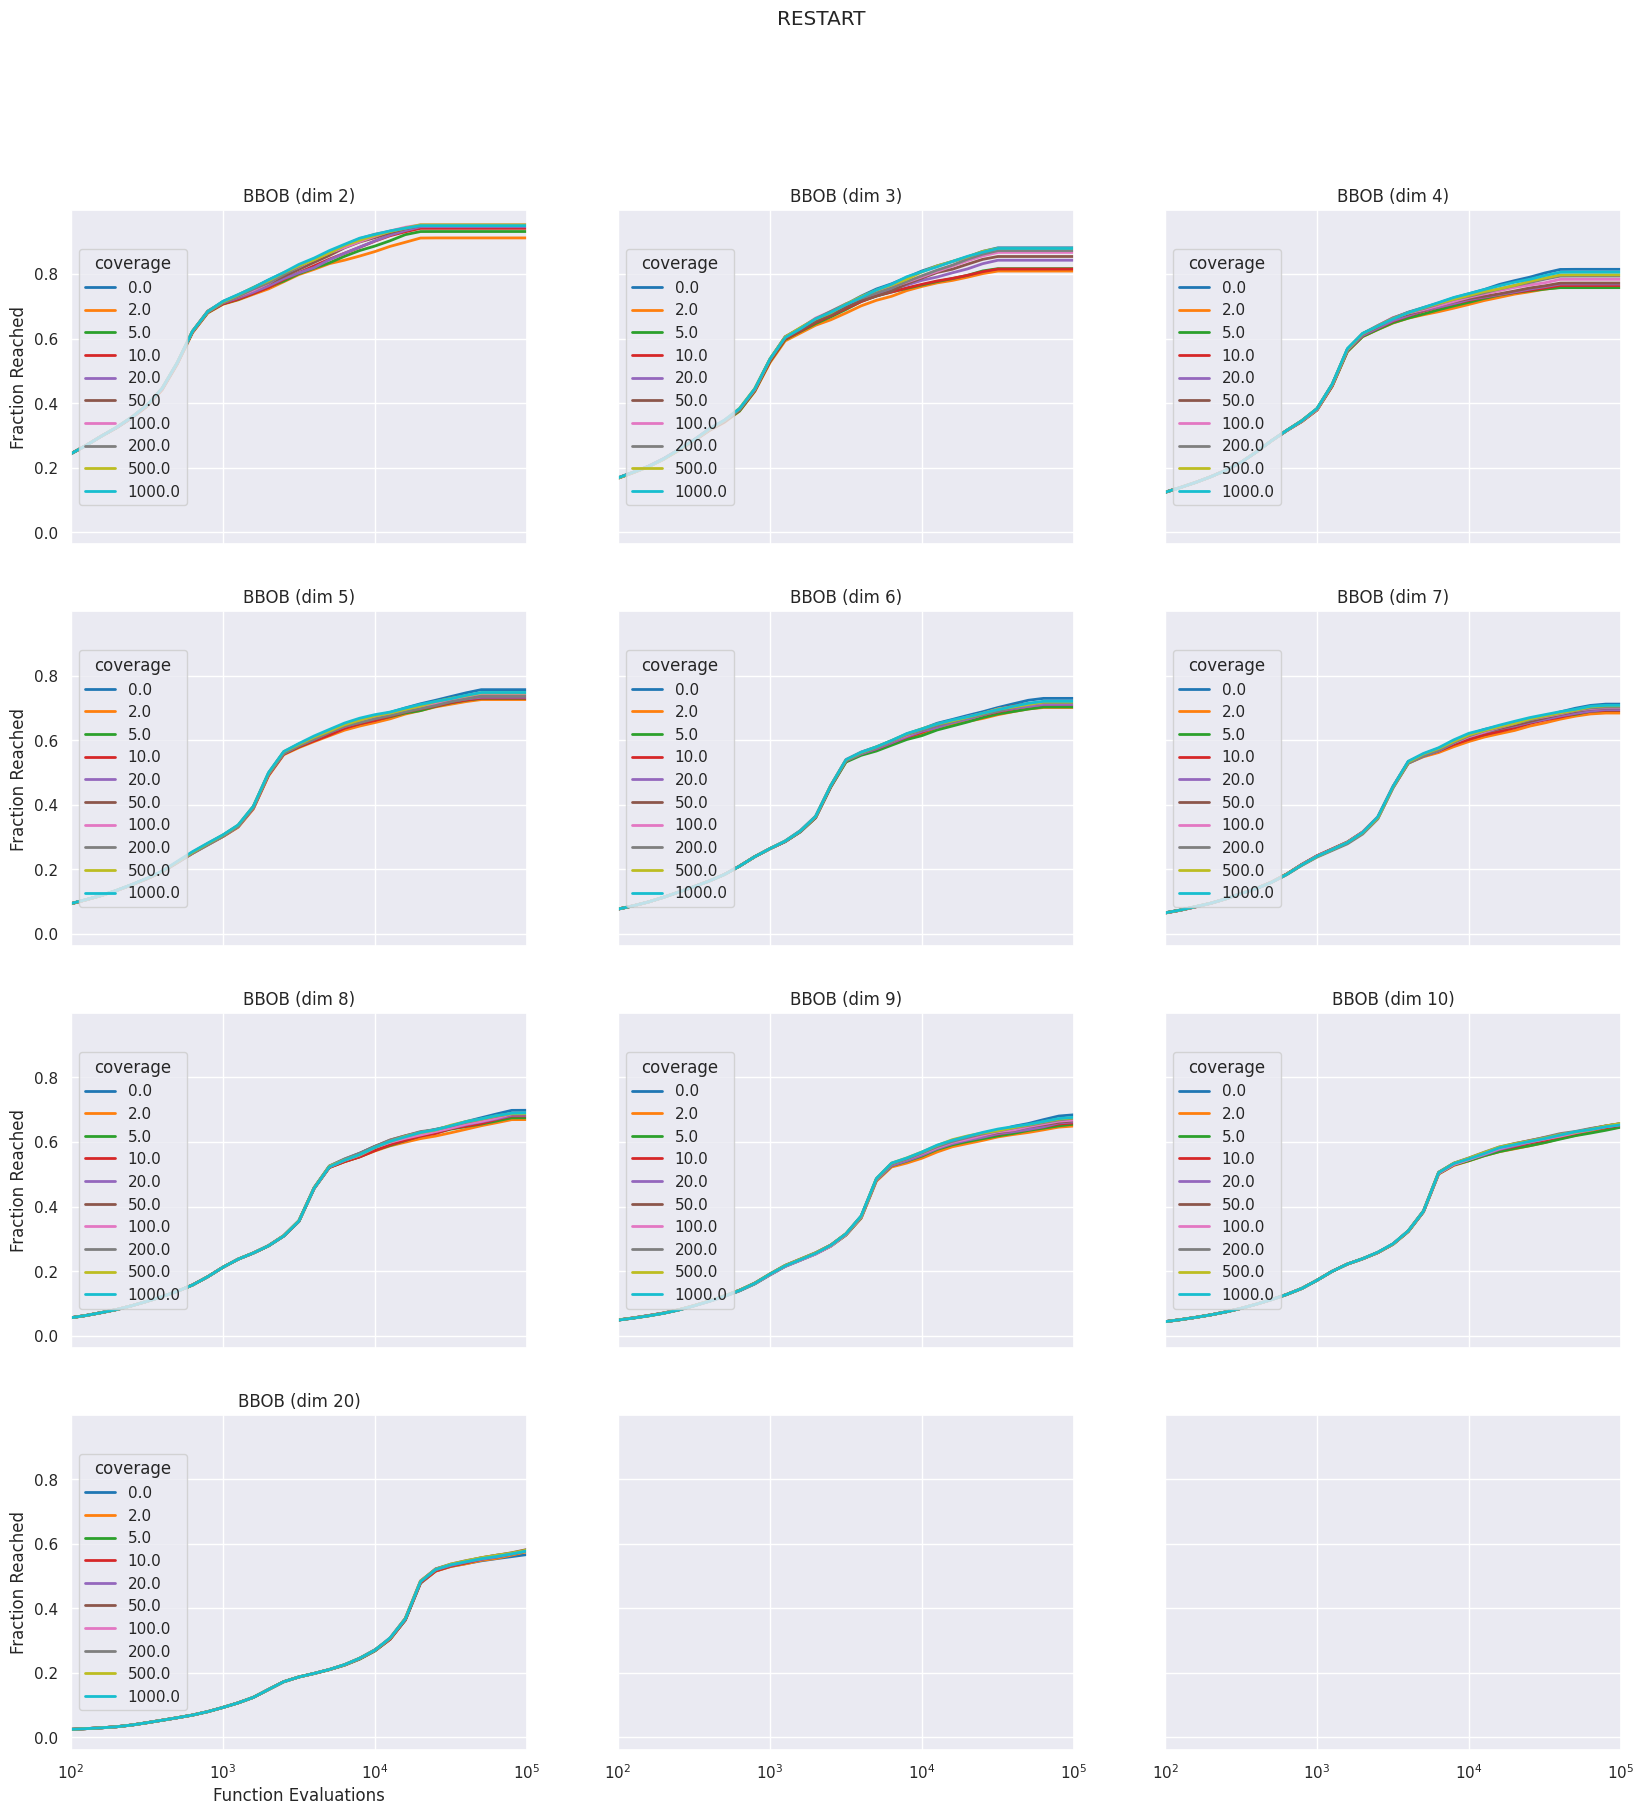

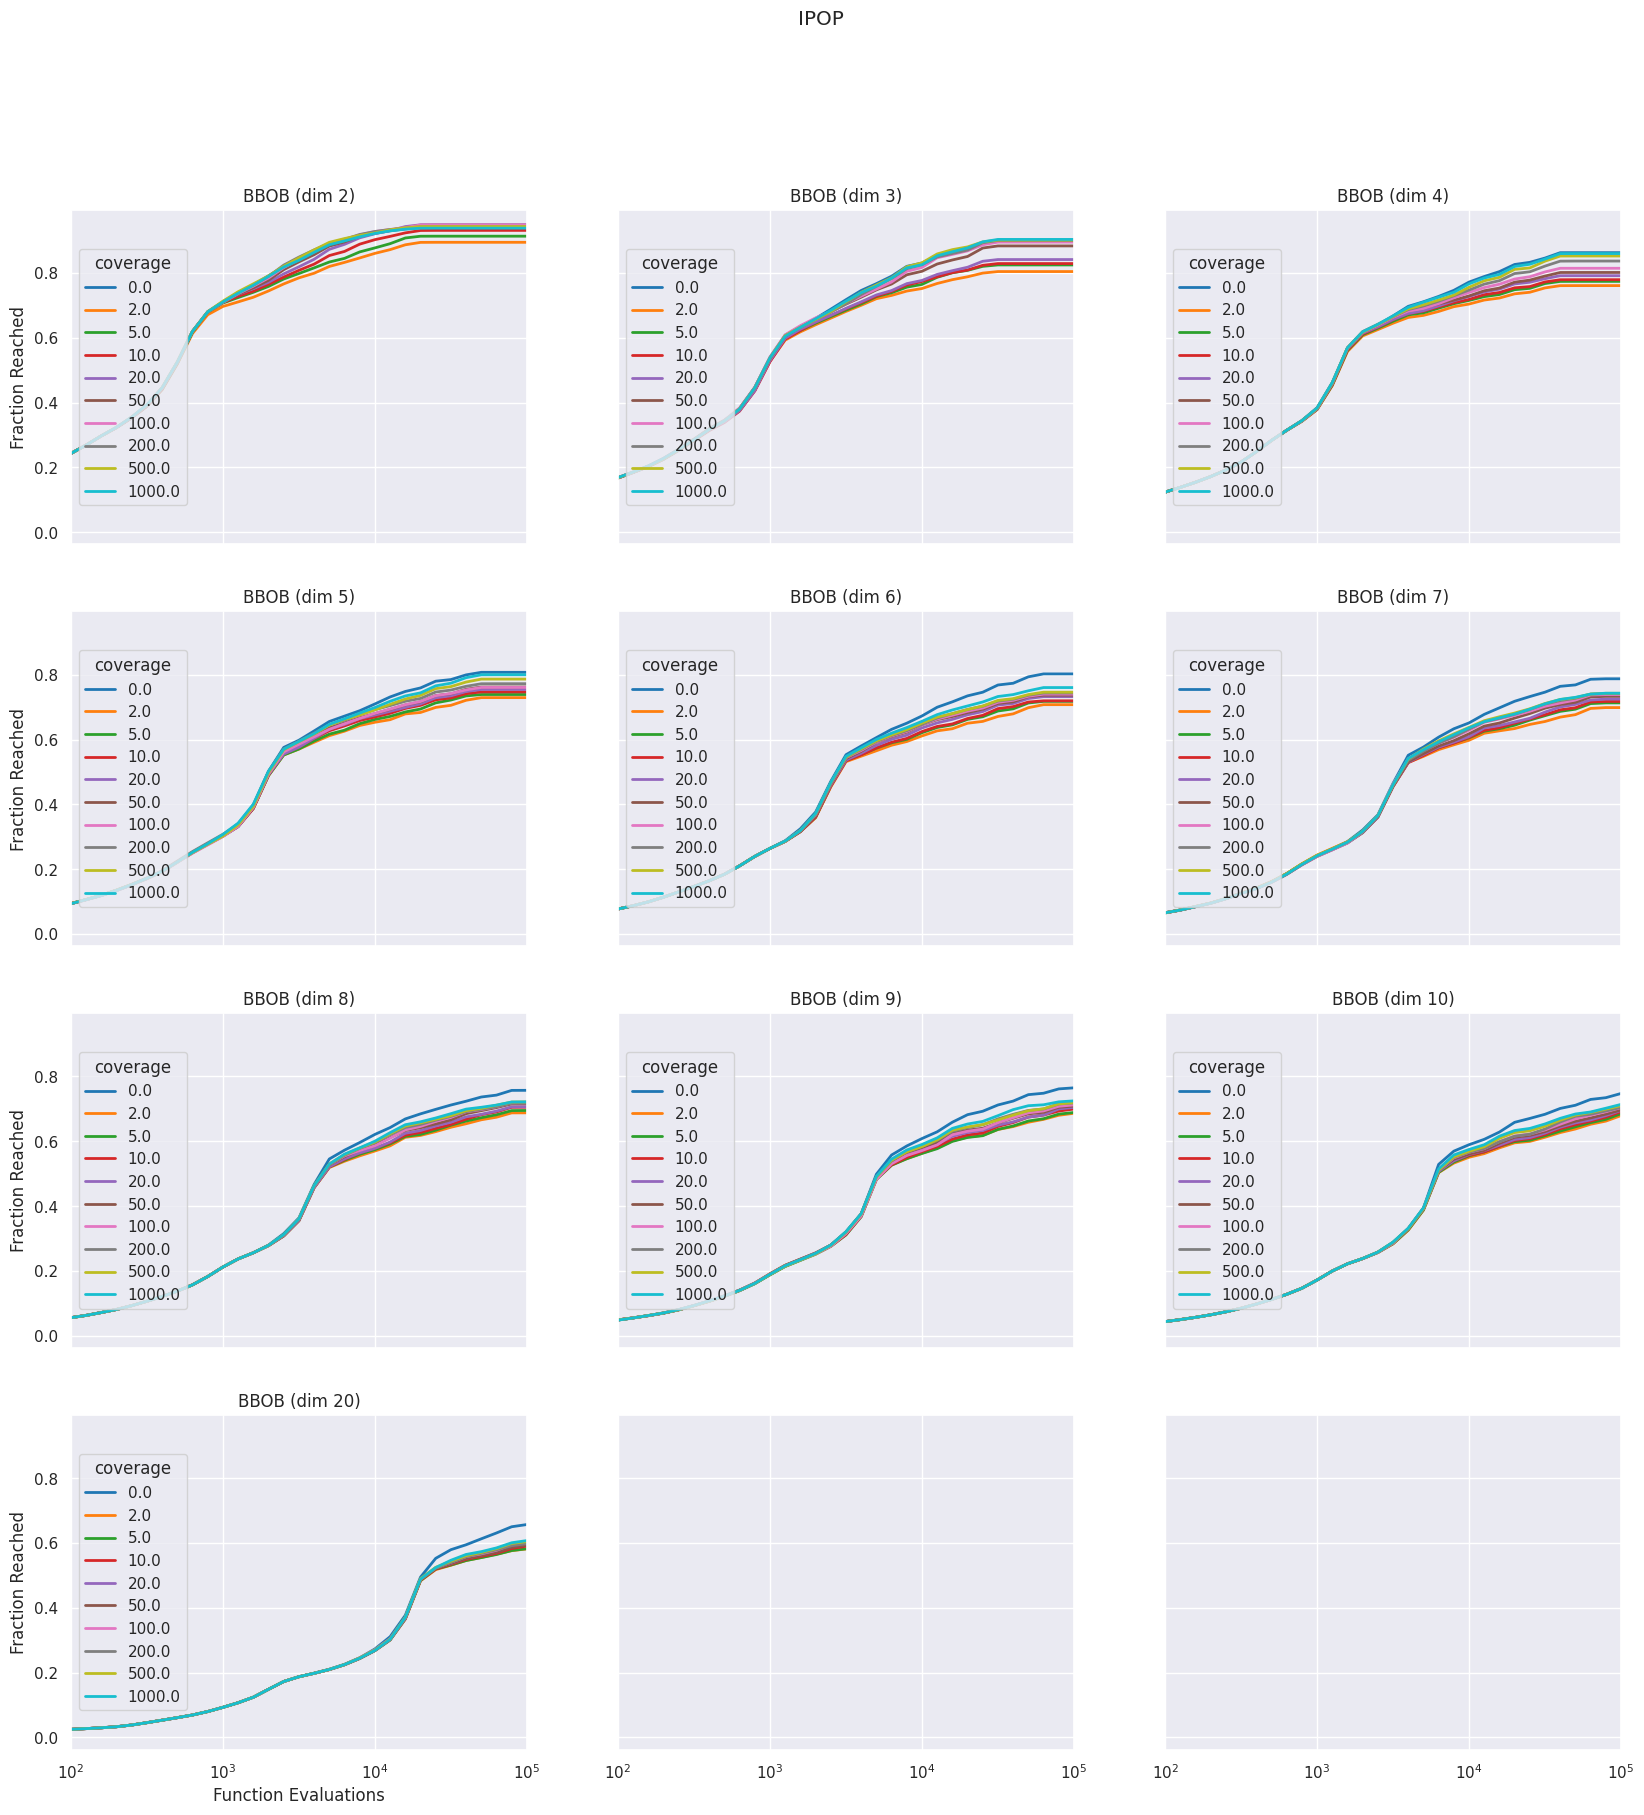

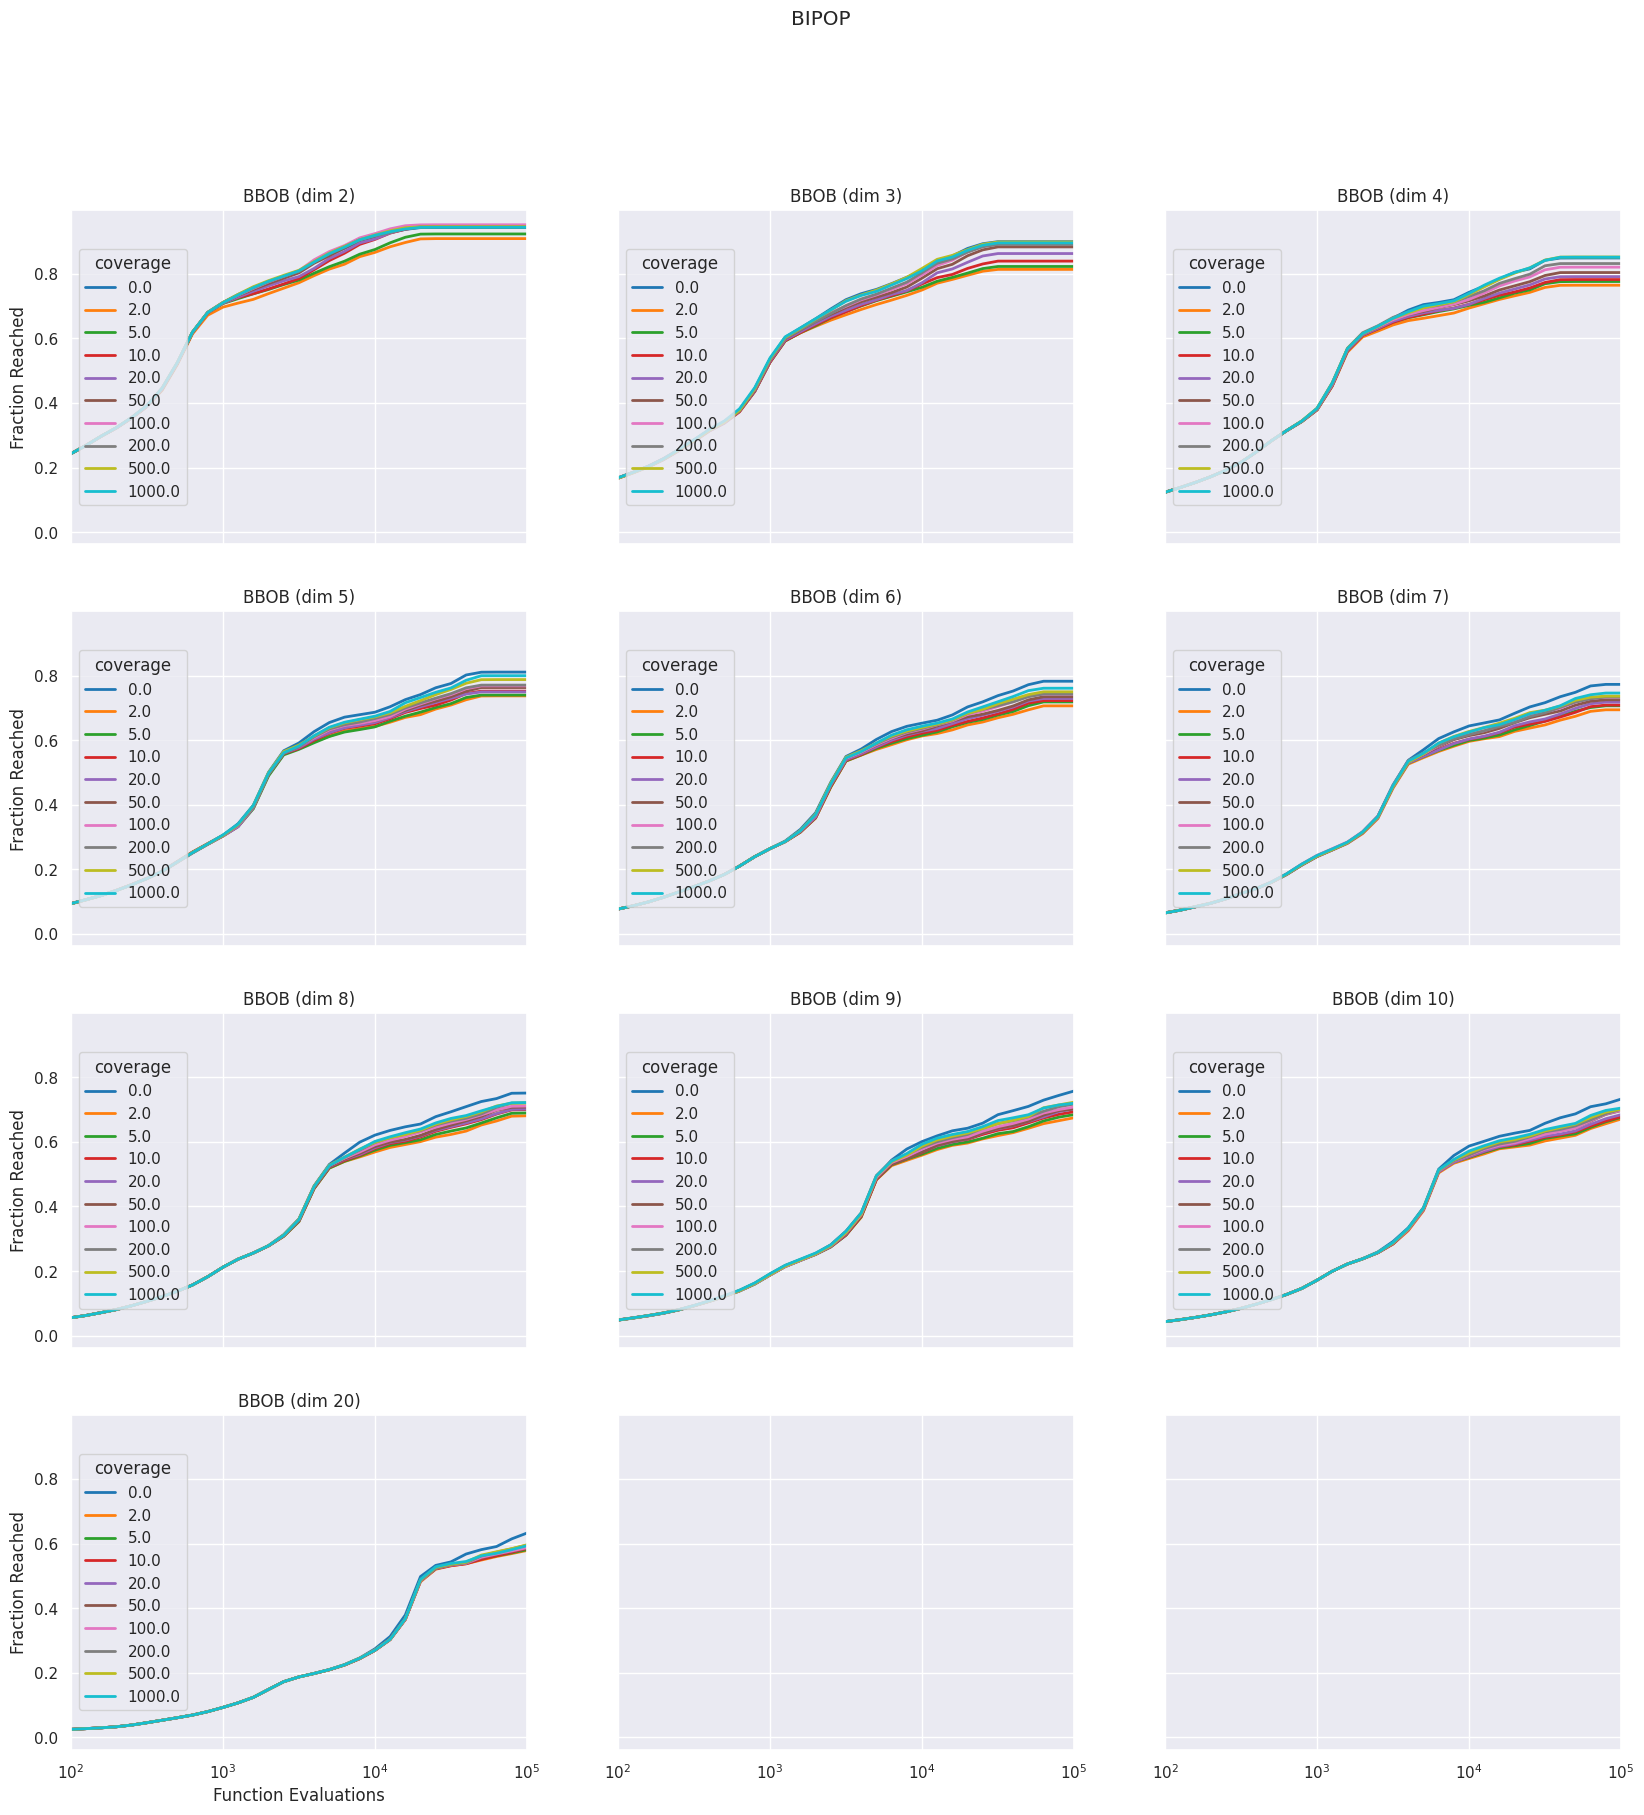

In [15]:
for method in ("RESTART", "IPOP", "BIPOP"):
    dims = (2, 3, 4, 5, 6, 7, 8, 9, 10, 20)
    f, axes = plt.subplots(4, 3, sharey=True, sharex=True, figsize=(20, 20))
    f.suptitle(method)
    for dim, ax in zip(dims, axes.ravel()):
        sbs.set_theme(style="darkgrid")
        sbs.lineplot(
            data.query(
                f"fid < 200 & dim == {dim} & coverage < 10000 & elitist == False & strategy == '{method}'"
            ).sort_values("coverage"),
            x="budget",
            y="ecdf",
            hue="coverage",
            errorbar=None,
            palette='tab10',
            lw=2,
            ax=ax
        )
        sbs.move_legend(ax, "center left")
        ax.set_xscale("log")
        ax.set_xlim(1e2, 1e5)
        ax.set_ylabel("Fraction Reached")
        ax.set_xlabel("Function Evaluations")
        ax.set_title(f"BBOB (dim {dim})")
    plt.tight_layout() 
    plt.savefig(f"figures/aggregated_ecdf_bbob_per_dim_{method}.pdf")